In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configurar visualizações
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

df = pd.read_csv('../data/despesas_hugomotta.csv')

print("Informações básicas do dataset:")
print(f"Total de registros: {len(df):,}")
print(f"Período: {df['data_emissao'].min()} a {df['data_emissao'].max()}")
print(f"Parlamentar: {df['nome_parlamentar'].iloc[0]}")
print(f"Total gasto: R$ {df['valor_liquido'].sum():,.2f}")
print(f"Número de fornecedores únicos: {df['fornecedor'].nunique()}")

df.info()


Informações básicas do dataset:
Total de registros: 6,483
Período: 2011-01-25 a 2024-12-31
Parlamentar: Hugo Motta
Total gasto: R$ 6,388,389.79
Número de fornecedores únicos: 615
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6483 entries, 0 to 6482
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   nome_parlamentar            6483 non-null   object 
 1   cpf                         6482 non-null   float64
 2   id_deputado                 6483 non-null   int64  
 3   ano_legislatura             6483 non-null   int64  
 4   id_legislatura              6483 non-null   int64  
 5   sigla_uf                    6483 non-null   object 
 6   sigla_partido               6483 non-null   object 
 7   categoria_despesa           6483 non-null   object 
 8   subcategoria_despesa        1510 non-null   object 
 9   fornecedor                  6483 non-null   object 
 10  cnpj_cpf_fornecedor      

In [105]:
# Preparação dos dados para análise
# Converter datas para datetime
df['data_emissao'] = pd.to_datetime(df['data_emissao'], errors='coerce')
df['data_pagamento_restituicao'] = pd.to_datetime(df['data_pagamento_restituicao'], errors='coerce')

# Limpeza e preparação dos dados numéricos
df['valor_liquido'] = pd.to_numeric(df['valor_liquido'], errors='coerce')
df['valor_documento'] = pd.to_numeric(df['valor_documento'], errors='coerce')
df['valor_restituicao'] = pd.to_numeric(df['valor_restituicao'], errors='coerce')

# Adicionar colunas derivadas para análise
df['ano'] = df['data_emissao'].dt.year
df['mes'] = df['data_emissao'].dt.month
df['dia_semana'] = df['data_emissao'].dt.dayofweek
df['dia_mes'] = df['data_emissao'].dt.day

# Verificar dados limpos
print("Dados após limpeza:")
print(f"Registros com valor_liquido válido: {df['valor_liquido'].notna().sum()}")
print(f"Registros com data_emissao válida: {df['data_emissao'].notna().sum()}")
print(f"Valor total válido: R$ {df['valor_liquido'].sum():,.2f}")

df.head(3)


Dados após limpeza:
Registros com valor_liquido válido: 6483
Registros com data_emissao válida: 6483
Valor total válido: R$ 6,388,389.79


,nome_parlamentar,cpf,id_deputado,ano_legislatura,id_legislatura,sigla_uf,sigla_partido,categoria_despesa,subcategoria_despesa,fornecedor,...,numero_parcela,nome_passageiro,descricao_passagem_aerea,data_pagamento_restituicao,valor_restituicao,url_documento,ano,mes,dia_semana,dia_mes
0,Hugo Motta,NaN,160674,2007,53,PB,REPUBLICANOS,PASSAGEM AÉREA - REEMBOLSO,NaN,CLASSIC VIAGENS E TURISMO LTDA,...,0,NaN,JPA/BSB,NaT,NaN,NaN,2011,1,1,25
1,Hugo Motta,4.796249e+09,160674,2011,54,PB,PMDB,COMBUSTÍVEIS E LUBRIFICANTES.,Veículos Automotores,Auto Shopping Derivados de Petroleo Ltda,...,0,NaN,NaN,NaT,NaN,NaN,2013,5,3,2
2,Hugo Motta,4.796249e+09,160674,2011,54,PB,PMDB,COMBUSTÍVEIS E LUBRIFICANTES.,Sem especificações,G. M. RANGEL COMBUSTIVEL LTDA,...,0,NaN,NaN,NaT,NaN,NaN,2011,7,2,6


In [106]:
# =============================================================================
# 1. DETECÇÃO DE VALORES ATÍPICOS (OUTLIERS)
# =============================================================================

def detect_outliers_iqr(df, column):
    """Detecta outliers usando método IQR"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

def detect_outliers_zscore(df, column, threshold=3):
    """Detecta outliers usando Z-score"""
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    return df[z_scores > threshold]

# Detectar outliers por valor
outliers_iqr = detect_outliers_iqr(df, 'valor_liquido')
outliers_zscore = detect_outliers_zscore(df, 'valor_liquido')

print("🔍 ANÁLISE DE VALORES ATÍPICOS")
print("="*50)
print(f"Outliers por IQR: {len(outliers_iqr)} transações")
print(f"Outliers por Z-score: {len(outliers_zscore)} transações")
print(f"Percentual de outliers (IQR): {len(outliers_iqr)/len(df)*100:.2f}%")

# Top 10 maiores gastos
top_gastos = df.nlargest(10, 'valor_liquido')[['data_emissao', 'fornecedor', 'categoria_despesa', 'valor_liquido']]
print("\n🏆 TOP 10 MAIORES GASTOS:")
print(top_gastos.to_string(index=False))


🔍 ANÁLISE DE VALORES ATÍPICOS
Outliers por IQR: 569 transações
Outliers por Z-score: 188 transações
Percentual de outliers (IQR): 8.78%

🏆 TOP 10 MAIORES GASTOS:
data_emissao                                           fornecedor                             categoria_despesa  valor_liquido
  2014-12-16                      Peixoto Advocacia & Consultoria CONSULTORIAS, PESQUISAS E TRABALHOS TÉCNICOS.        37000.0
  2019-03-22 SIGMA-ALGEBRA SERVICOS DE PESQUISAS E SOLUCOES LTDA. CONSULTORIAS, PESQUISAS E TRABALHOS TÉCNICOS.        32000.0
  2019-01-15                    GP COBERTURA JORNALISTICA LTDA ME          DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.        30000.0
  2015-08-31                              HERCULES SIDNEY FIRMINO            LOCAÇÃO OU FRETAMENTO DE AERONAVES        24150.0
  2022-12-29                    GP COBERTURA JORNALISTICA LTDA ME          DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.        18000.0
  2015-09-11                              HERCULES SIDNEY FIRMINO           

In [107]:
# =============================================================================
# 2. DETECÇÃO DE NÚMEROS REDONDOS (POSSÍVEIS NOTAS FISCAIS FALSAS)
# =============================================================================

def detect_round_numbers(df, column, thresholds=[100, 500, 1000]):
    """Detecta valores redondos suspeitos"""
    round_transactions = []
    
    for threshold in thresholds:
        # Valores que são múltiplos exatos do threshold
        condition = (df[column] % threshold == 0) & (df[column] >= threshold)
        round_df = df[condition].copy()
        round_df['round_type'] = f'Múltiplo de {threshold}'
        round_transactions.append(round_df)
    
    return pd.concat(round_transactions, ignore_index=True) if round_transactions else pd.DataFrame()

round_numbers = detect_round_numbers(df, 'valor_liquido')

print("🎯 ANÁLISE DE NÚMEROS REDONDOS")
print("="*50)
print(f"Transações com valores redondos: {len(round_numbers)}")
print(f"Percentual: {len(round_numbers)/len(df)*100:.2f}%")

if len(round_numbers) > 0:
    print("\n📊 DISTRIBUIÇÃO DE VALORES REDONDOS:")
    round_summary = round_numbers.groupby('round_type').agg({
        'valor_liquido': ['count', 'sum', 'mean']
    }).round(2)
    print(round_summary)
    
    print("\n🎯 EXEMPLOS DE VALORES REDONDOS SUSPEITOS:")
    exemplos = round_numbers[round_numbers['valor_liquido'] >= 1000].head(10)
    if len(exemplos) > 0:
        print(exemplos[['data_emissao', 'fornecedor', 'categoria_despesa', 'valor_liquido', 'round_type']].to_string(index=False))
    else:
        print("Nenhum valor redondo >= R$ 1.000 encontrado")


🎯 ANÁLISE DE NÚMEROS REDONDOS
Transações com valores redondos: 3260
Percentual: 50.29%

📊 DISTRIBUIÇÃO DE VALORES REDONDOS:
                 valor_liquido                    
                         count        sum     mean
round_type                                        
Múltiplo de 100           1869  3644200.0  1949.81
Múltiplo de 1000           596  2619000.0  4394.30
Múltiplo de 500            795  2965500.0  3730.19

🎯 EXEMPLOS DE VALORES REDONDOS SUSPEITOS:
data_emissao                                         fornecedor                                            categoria_despesa  valor_liquido      round_type
  2014-01-27           ROBERTO CLEBIO MESSIAS LEITAO FILHO - ME                CONSULTORIAS, PESQUISAS E TRABALHOS TÉCNICOS.         5900.0 Múltiplo de 100
  2014-05-26 Glick Serviços de Desenvolvimento de Software Ltda                         DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.         1500.0 Múltiplo de 100
  2013-08-06  PB AGORA SERVIÇOS DE INTERNET E COMUNICAÇOES 

In [108]:
# =============================================================================
# 3. DETECÇÃO DE TRANSAÇÕES DUPLICADAS OU SIMILARES
# =============================================================================

def detect_duplicates(df):
    """Detecta transações duplicadas e suspeitas"""
    # Duplicatas exatas por valor, fornecedor e data
    exact_duplicates = df[df.duplicated(subset=['valor_liquido', 'fornecedor', 'data_emissao'], keep=False)]
    
    # Duplicatas por valor e fornecedor (datas diferentes)
    value_supplier_duplicates = df[df.duplicated(subset=['valor_liquido', 'fornecedor'], keep=False)]
    
    # Múltiplas transações no mesmo dia com o mesmo fornecedor
    same_day_supplier = df.groupby(['data_emissao', 'fornecedor']).size().reset_index(name='count')
    same_day_supplier = same_day_supplier[same_day_supplier['count'] > 1]
    
    return exact_duplicates, value_supplier_duplicates, same_day_supplier

exact_dups, value_supplier_dups, same_day_dups = detect_duplicates(df)

print("🔄 ANÁLISE DE TRANSAÇÕES DUPLICADAS")
print("="*50)
print(f"Duplicatas exatas (valor + fornecedor + data): {len(exact_dups)}")
print(f"Duplicatas por valor e fornecedor: {len(value_supplier_dups)}")
print(f"Dias com múltiplas transações do mesmo fornecedor: {len(same_day_dups)}")

if len(exact_dups) > 0:
    print("\n🚨 DUPLICATAS EXATAS ENCONTRADAS:")
    exemplos_dups = exact_dups[['data_emissao', 'fornecedor', 'categoria_despesa', 'valor_liquido']].iloc[:10]
    print(exemplos_dups.to_string(index=False))

if len(same_day_dups) > 0:
    print("\n📅 DIAS COM MÚLTIPLAS TRANSAÇÕES DO MESMO FORNECEDOR:")
    top_same_day = same_day_dups.sort_values('count', ascending=False).head(10)
    print(top_same_day.to_string(index=False))


🔄 ANÁLISE DE TRANSAÇÕES DUPLICADAS
Duplicatas exatas (valor + fornecedor + data): 279
Duplicatas por valor e fornecedor: 3203
Dias com múltiplas transações do mesmo fornecedor: 689

🚨 DUPLICATAS EXATAS ENCONTRADAS:
data_emissao                      fornecedor                                            categoria_despesa  valor_liquido
  2011-06-27               KMC LOCADORA LTDA LOCAÇÃO DE VEÍCULOS AUTOMOTORES OU FRETAMENTO DE EMBARCAÇÕES        5000.00
  2013-10-23             Cia Aérea - AVIANCA                                         PASSAGEM AÉREA - RPA         475.95
  2014-11-27   JOSELY FERNANDA DO NASCIMENTO                         DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.       15000.00
  2011-08-29               KMC LOCADORA LTDA LOCAÇÃO DE VEÍCULOS AUTOMOTORES OU FRETAMENTO DE EMBARCAÇÕES        5000.00
  2013-10-23             Cia Aérea - AVIANCA                                         PASSAGEM AÉREA - RPA        1017.55
  2012-02-09              Cia Aérea - WEBJET               

In [109]:
# =============================================================================
# 4. ANÁLISE DE PADRÕES TEMPORAIS SUSPEITOS
# =============================================================================

def analyze_temporal_patterns(df):
    """Analisa padrões temporais suspeitos"""
    # Transações em fins de semana (sábado=5, domingo=6)
    weekend_transactions = df[df['dia_semana'].isin([5, 6])]
    
    # Transações em finais de mês (últimos 3 dias)
    end_of_month = df[df['dia_mes'] >= 28]
    
    # Concentração de gastos por mês
    monthly_spending = df.groupby(['ano', 'mes']).agg({
        'valor_liquido': ['sum', 'count', 'mean']
    }).round(2)
    
    # Picos de gastos (meses com gastos > 2 desvios padrão da média)
    monthly_totals = df.groupby(['ano', 'mes'])['valor_liquido'].sum()
    mean_monthly = monthly_totals.mean()
    std_monthly = monthly_totals.std()
    spike_months = monthly_totals[monthly_totals > mean_monthly + 2*std_monthly]
    
    return weekend_transactions, end_of_month, monthly_spending, spike_months

weekend_trans, end_month_trans, monthly_spend, spike_months = analyze_temporal_patterns(df)

print("📅 ANÁLISE DE PADRÕES TEMPORAIS")
print("="*50)
print(f"Transações em fins de semana: {len(weekend_trans)} ({len(weekend_trans)/len(df)*100:.2f}%)")
print(f"Transações em finais de mês: {len(end_month_trans)} ({len(end_month_trans)/len(df)*100:.2f}%)")
print(f"Meses com picos de gastos: {len(spike_months)}")

if len(weekend_trans) > 0:
    weekend_summary = weekend_trans.groupby('dia_semana').agg({
        'valor_liquido': ['count', 'sum', 'mean']
    }).round(2)
    print("\n📊 RESUMO TRANSAÇÕES FINS DE SEMANA:")
    print(weekend_summary)

if len(spike_months) > 0:
    print("\n📈 MESES COM PICOS DE GASTOS:")
    for idx, valor in spike_months.items():
        ano, mes = idx
        print(f"{mes:02d}/{ano}: R$ {valor:,.2f}")

# Análise de frequência por dia da semana
freq_dia_semana = df.groupby('dia_semana').size()
dias_semana = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab', 'Dom']
print("\n📊 DISTRIBUIÇÃO POR DIA DA SEMANA:")
for dia in freq_dia_semana.index:
    count = freq_dia_semana[dia]
    print(f"{dias_semana[dia]}: {count} transações ({count/len(df)*100:.1f}%)")


📅 ANÁLISE DE PADRÕES TEMPORAIS
Transações em fins de semana: 408 (6.29%)
Transações em finais de mês: 767 (11.83%)
Meses com picos de gastos: 5

📊 RESUMO TRANSAÇÕES FINS DE SEMANA:
           valor_liquido                   
                   count        sum    mean
dia_semana                                 
5                    251  158605.71  631.90
6                    157   94386.55  601.19

📈 MESES COM PICOS DE GASTOS:
12/2014: R$ 94,829.00
02/2018: R$ 83,606.48
03/2019: R$ 82,475.00
12/2022: R$ 142,170.04
12/2024: R$ 75,717.98

📊 DISTRIBUIÇÃO POR DIA DA SEMANA:
Seg: 1247 transações (19.2%)
Ter: 1343 transações (20.7%)
Qua: 1355 transações (20.9%)
Qui: 1220 transações (18.8%)
Sex: 910 transações (14.0%)
Sab: 251 transações (3.9%)
Dom: 157 transações (2.4%)


In [110]:
# =============================================================================
# 5. ANÁLISE DE CONCENTRAÇÃO DE FORNECEDORES
# =============================================================================

def analyze_supplier_concentration(df):
    """Analisa concentração de gastos por fornecedor"""
    # Gastos por fornecedor
    supplier_spending = df.groupby('fornecedor').agg({
        'valor_liquido': ['sum', 'count', 'mean'],
        'data_emissao': ['min', 'max']
    }).round(2)
    
    # Resetar índices multicoluna
    supplier_spending.columns = ['total_gasto', 'num_transacoes', 'gasto_medio', 'primeira_transacao', 'ultima_transacao']
    supplier_spending = supplier_spending.reset_index()
    
    # Calcular concentração (% do total)
    total_spending = df['valor_liquido'].sum()
    supplier_spending['percentual_total'] = (supplier_spending['total_gasto'] / total_spending * 100).round(2)
    
    # Identificar fornecedores suspeitos
    # Critério 1: Muito poucas transações mas valores altos
    high_value_few_trans = supplier_spending[
        (supplier_spending['num_transacoes'] <= 3) & 
        (supplier_spending['total_gasto'] > supplier_spending['total_gasto'].quantile(0.9))
    ]
    
    # Critério 2: Concentração excessiva (> 5% do total)
    high_concentration = supplier_spending[supplier_spending['percentual_total'] > 5]
    
    return supplier_spending, high_value_few_trans, high_concentration

supplier_analysis, high_value_few, high_concentration = analyze_supplier_concentration(df)

print("🏪 ANÁLISE DE CONCENTRAÇÃO DE FORNECEDORES")
print("="*50)
print(f"Total de fornecedores únicos: {len(supplier_analysis)}")
print(f"Fornecedores com poucas transações/altos valores: {len(high_value_few)}")
print(f"Fornecedores com alta concentração (>5%): {len(high_concentration)}")

# Top 10 fornecedores por valor total
print("\n💰 TOP 10 FORNECEDORES POR VALOR TOTAL:")
top_suppliers = supplier_analysis.nlargest(10, 'total_gasto')
print(top_suppliers[['fornecedor', 'total_gasto', 'num_transacoes', 'percentual_total']].to_string(index=False))

# Fornecedores suspeitos - poucas transações, valores altos
if len(high_value_few) > 0:
    print("\n🚨 FORNECEDORES SUSPEITOS - POUCAS TRANSAÇÕES, VALORES ALTOS:")
    print(high_value_few[['fornecedor', 'total_gasto', 'num_transacoes', 'percentual_total']].to_string(index=False))

# Análise de Pareto (80/20)
supplier_sorted = supplier_analysis.sort_values('total_gasto', ascending=False)
supplier_sorted['percentual_acumulado'] = supplier_sorted['percentual_total'].cumsum()
pareto_80 = supplier_sorted[supplier_sorted['percentual_acumulado'] <= 80]
print(f"\n📊 ANÁLISE DE PARETO:")
print(f"Fornecedores que representam 80% dos gastos: {len(pareto_80)} ({len(pareto_80)/len(supplier_analysis)*100:.1f}%)")


🏪 ANÁLISE DE CONCENTRAÇÃO DE FORNECEDORES
Total de fornecedores únicos: 615
Fornecedores com poucas transações/altos valores: 4
Fornecedores com alta concentração (>5%): 4

💰 TOP 10 FORNECEDORES POR VALOR TOTAL:
                                            fornecedor  total_gasto  num_transacoes  percentual_total
                     GP COBERTURA JORNALISTICA LTDA ME    490000.00              57              7.67
                                                   TAM    364418.61             540              5.70
                                       Cia Aérea - GOL    323239.98             554              5.06
                                       Cia Aérea - TAM    323075.23             544              5.06
              ROBERTO CLEBIO MESSIAS LEITAO FILHO - ME    282049.00              62              4.42
                         JOSELY FERNANDA DO NASCIMENTO    279000.00              36              4.37
Popsicle Digital Flavours Com. 360º Prod. Aud. Ltda ME    264000.00       

In [111]:
# =============================================================================
# 6. RELATÓRIO FINAL DE TRANSAÇÕES SUSPEITAS
# =============================================================================

def generate_suspicion_report(df, outliers, round_numbers, exact_dups, weekend_trans):
    """Gera relatório final com pontuação de suspeição"""
    
    # Criar DataFrame de suspeição
    suspicion_scores = []
    
    # Processar cada transação
    for idx, row in df.iterrows():
        score = 0
        flags = []
        
        # Verificar se é outlier
        if idx in outliers_iqr.index:
            score += 3
            flags.append("OUTLIER_VALOR")
        
        # Verificar se é valor redondo
        if len(round_numbers) > 0 and idx in round_numbers.index:
            score += 2
            flags.append("VALOR_REDONDO")
        
        # Verificar se é duplicata
        if len(exact_dups) > 0 and idx in exact_dups.index:
            score += 4
            flags.append("DUPLICATA")
        
        # Verificar se é fim de semana
        if idx in weekend_trans.index:
            score += 1
            flags.append("FIM_SEMANA")
        
        # Verificar valores muito altos
        if row['valor_liquido'] > df['valor_liquido'].quantile(0.95):
            score += 2
            flags.append("VALOR_ALTO")
        
        # Só adicionar se houver suspeita
        if score > 0:
            suspicion_scores.append({
                'indice': idx,
                'data_emissao': row['data_emissao'],
                'fornecedor': row['fornecedor'],
                'categoria_despesa': row['categoria_despesa'],
                'valor_liquido': row['valor_liquido'],
                'score_suspeita': score,
                'flags': ', '.join(flags)
            })
    
    return pd.DataFrame(suspicion_scores)

# Gerar relatório de suspeição
suspicion_report = generate_suspicion_report(df, outliers_iqr, round_numbers, exact_dups, weekend_trans)

print("📋 RELATÓRIO FINAL DE TRANSAÇÕES SUSPEITAS")
print("="*60)
print(f"Total de transações analisadas: {len(df):,}")
print(f"Transações com alguma suspeita: {len(suspicion_report):,}")
print(f"Percentual de transações suspeitas: {len(suspicion_report)/len(df)*100:.2f}%")

if len(suspicion_report) > 0:
    # Resumo por score
    print("\n🎯 DISTRIBUIÇÃO DE SCORES DE SUSPEITA:")
    score_distribution = suspicion_report.groupby('score_suspeita').size().sort_index(ascending=False)
    for score, count in score_distribution.items():
        print(f"Score {score}: {count} transações")
    
    # Top 20 mais suspeitas
    print("\n🚨 TOP 20 TRANSAÇÕES MAIS SUSPEITAS:")
    top_suspicious = suspicion_report.nlargest(20, 'score_suspeita')
    
    for _, row in top_suspicious.iterrows():
        print(f"Score: {row['score_suspeita']} | Data: {row['data_emissao'].strftime('%d/%m/%Y') if pd.notna(row['data_emissao']) else 'N/A'} | "
              f"Fornecedor: {row['fornecedor'][:30]}... | Valor: R$ {row['valor_liquido']:,.2f}")
        print(f"  Flags: {row['flags']}")
        print("-" * 80)

print("\n✅ ANÁLISE CONCLUÍDA!")
print("Revise as transações com maior score de suspeita para investigação detalhada.")


📋 RELATÓRIO FINAL DE TRANSAÇÕES SUSPEITAS
Total de transações analisadas: 6,483
Transações com alguma suspeita: 3,850
Percentual de transações suspeitas: 59.39%

🎯 DISTRIBUIÇÃO DE SCORES DE SUSPEITA:
Score 11: 35 transações
Score 9: 10 transações
Score 7: 137 transações
Score 6: 104 transações
Score 5: 225 transações
Score 4: 156 transações
Score 3: 369 transações
Score 2: 2669 transações
Score 1: 145 transações

🚨 TOP 20 TRANSAÇÕES MAIS SUSPEITAS:
Score: 11 | Data: 27/06/2011 | Fornecedor: KMC LOCADORA LTDA... | Valor: R$ 5,000.00
  Flags: OUTLIER_VALOR, VALOR_REDONDO, DUPLICATA, VALOR_ALTO
--------------------------------------------------------------------------------
Score: 11 | Data: 27/11/2014 | Fornecedor: JOSELY FERNANDA DO NASCIMENTO... | Valor: R$ 15,000.00
  Flags: OUTLIER_VALOR, VALOR_REDONDO, DUPLICATA, VALOR_ALTO
--------------------------------------------------------------------------------
Score: 11 | Data: 29/08/2011 | Fornecedor: KMC LOCADORA LTDA... | Valor: R$ 5,00

In [112]:
# =============================================================================
# 7. ANÁLISES COMPLEMENTARES E MELHORIAS
# =============================================================================

# 7.1 ANÁLISE POR CATEGORIA DE DESPESA
print("📊 ANÁLISE POR CATEGORIA DE DESPESA")
print("="*60)

categoria_analysis = df.groupby('categoria_despesa').agg({
    'valor_liquido': ['sum', 'count', 'mean', 'std'],
    'fornecedor': 'nunique'
}).round(2)

categoria_analysis.columns = ['total_gasto', 'num_transacoes', 'valor_medio', 'desvio_padrao', 'num_fornecedores']
categoria_analysis = categoria_analysis.reset_index()
categoria_analysis['percentual_total'] = (categoria_analysis['total_gasto'] / df['valor_liquido'].sum() * 100).round(2)

# Ordenar por valor total
categoria_analysis = categoria_analysis.sort_values('total_gasto', ascending=False)

print("💰 GASTOS POR CATEGORIA:")
for _, row in categoria_analysis.head(10).iterrows():
    print(f"{row['categoria_despesa'][:50]:<50} | R$ {row['total_gasto']:>10,.2f} | {row['num_transacoes']:>4} trans | Média: R$ {row['valor_medio']:>7,.2f} | {row['percentual_total']:>5.1f}%")

# Categorias com valores médios muito altos (possível superfaturamento)
high_avg_categories = categoria_analysis[categoria_analysis['valor_medio'] > categoria_analysis['valor_medio'].quantile(0.8)]
print(f"\n🚨 CATEGORIAS COM VALORES MÉDIOS SUSPEITOS:")
for _, row in high_avg_categories.iterrows():
    print(f"{row['categoria_despesa'][:50]:<50} | Média: R$ {row['valor_medio']:>7,.2f} | {row['num_transacoes']:>4} trans | {row['percentual_total']:>5.1f}%")


📊 ANÁLISE POR CATEGORIA DE DESPESA
💰 GASTOS POR CATEGORIA:
DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.               | R$ 2,927,464.72 | 1419 trans | Média: R$ 2,063.05 |  45.8%
PASSAGEM AÉREA - RPA                               | R$ 884,316.15 | 1542 trans | Média: R$  573.49 |  13.8%
COMBUSTÍVEIS E LUBRIFICANTES.                      | R$ 599,517.61 | 1510 trans | Média: R$  397.03 |   9.4%
PASSAGEM AÉREA - SIGEPA                            | R$ 550,094.79 |  782 trans | Média: R$  703.45 |   8.6%
CONSULTORIAS, PESQUISAS E TRABALHOS TÉCNICOS.      | R$ 436,451.91 |   67 trans | Média: R$ 6,514.21 |   6.8%
LOCAÇÃO OU FRETAMENTO DE VEÍCULOS AUTOMOTORES      | R$ 324,600.60 |   57 trans | Média: R$ 5,694.75 |   5.1%
LOCAÇÃO DE VEÍCULOS AUTOMOTORES OU FRETAMENTO DE E | R$ 240,652.08 |   59 trans | Média: R$ 4,078.85 |   3.8%
TELEFONIA                                          | R$ 159,237.95 |  507 trans | Média: R$  314.08 |   2.5%
PASSAGEM AÉREA - REEMBOLSO                         | R$ 124,530

In [113]:
# 7.2 ANÁLISE DE EVOLUÇÃO TEMPORAL E SAZONALIDADE
print("\n📈 ANÁLISE DE EVOLUÇÃO TEMPORAL")
print("="*60)

# Gastos por ano
yearly_spending = df.groupby('ano').agg({
    'valor_liquido': ['sum', 'count', 'mean'],
    'fornecedor': 'nunique'
}).round(2)

yearly_spending.columns = ['total_gasto', 'num_transacoes', 'valor_medio', 'num_fornecedores']
yearly_spending = yearly_spending.reset_index()

print("💰 GASTOS POR ANO:")
for _, row in yearly_spending.iterrows():
    print(f"{row['ano']} | R$ {row['total_gasto']:>10,.2f} | {row['num_transacoes']:>4} trans | {row['num_fornecedores']:>3} fornecedores")

# Identificar anos com gastos anômalos
mean_yearly = yearly_spending['total_gasto'].mean()
std_yearly = yearly_spending['total_gasto'].std()
anomalous_years = yearly_spending[yearly_spending['total_gasto'] > mean_yearly + 1.5*std_yearly]

print(f"\n🚨 ANOS COM GASTOS ANÔMALOS:")
for _, row in anomalous_years.iterrows():
    print(f"{row['ano']} | R$ {row['total_gasto']:>10,.2f} | {((row['total_gasto'] - mean_yearly) / mean_yearly * 100):>5.1f}% acima da média")

# Análise de sazonalidade (meses com mais gastos)
monthly_pattern = df.groupby('mes')['valor_liquido'].agg(['sum', 'count', 'mean']).round(2)
monthly_pattern.columns = ['total_gasto', 'num_transacoes', 'valor_medio']
monthly_pattern = monthly_pattern.reset_index()

print(f"\n📊 SAZONALIDADE - GASTOS POR MÊS:")
meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
for _, row in monthly_pattern.iterrows():
    mes_nome = meses[int(row['mes'])-1]
    print(f"{mes_nome} | R$ {row['total_gasto']:>10,.2f} | {row['num_transacoes']:>4} trans")



📈 ANÁLISE DE EVOLUÇÃO TEMPORAL
💰 GASTOS POR ANO:
2011.0 | R$ 347,500.51 | 542.0 trans | 127.0 fornecedores
2012.0 | R$ 374,426.58 | 471.0 trans | 112.0 fornecedores
2013.0 | R$ 375,324.33 | 456.0 trans | 87.0 fornecedores
2014.0 | R$ 443,991.60 | 369.0 trans | 60.0 fornecedores
2015.0 | R$ 446,591.81 | 509.0 trans | 73.0 fornecedores
2016.0 | R$ 449,758.51 | 439.0 trans | 77.0 fornecedores
2017.0 | R$ 443,134.36 | 446.0 trans | 78.0 fornecedores
2018.0 | R$ 419,525.97 | 392.0 trans | 85.0 fornecedores
2019.0 | R$ 535,900.61 | 465.0 trans | 65.0 fornecedores
2020.0 | R$ 450,360.21 | 456.0 trans | 88.0 fornecedores
2021.0 | R$ 512,601.36 | 534.0 trans | 93.0 fornecedores
2022.0 | R$ 493,337.57 | 438.0 trans | 81.0 fornecedores
2023.0 | R$ 556,619.81 | 478.0 trans | 74.0 fornecedores
2024.0 | R$ 539,316.56 | 488.0 trans | 73.0 fornecedores

🚨 ANOS COM GASTOS ANÔMALOS:
2023.0 | R$ 556,619.81 |  22.0% acima da média

📊 SAZONALIDADE - GASTOS POR MÊS:
Jan | R$ 366,984.70 | 353.0 trans
Fev | 

In [114]:
# =============================================================================
# ANÁLISE PRIORITÁRIA DE CNPJs - FORNECEDORES MAIS SUSPEITOS
# =============================================================================

def extract_priority_cnpjs(df, suspicion_report):
    """Extrai CNPJs prioritários baseado nos fornecedores mais suspeitos"""
    
    print("🎯 CNPJS PRIORITÁRIOS PARA INVESTIGAÇÃO")
    print("="*80)
    
    # 1. Fornecedores com transações de score máximo (≥ 11)
    critical_cases = suspicion_report[suspicion_report['score_suspeita'] >= 11]
    critical_suppliers = critical_cases['fornecedor'].unique() if len(critical_cases) > 0 else []
    
    # 2. Fornecedores com alta concentração de gastos (> 5% do total)
    high_concentration_suppliers = ['GP COBERTURA JORNALISTICA LTDA ME', 'TAM', 'Cia Aérea - GOL', 'Cia Aérea - TAM']
    
    # 3. Fornecedores com valores únicos muito altos
    high_value_single = ['Peixoto Advocacia & Consultoria', 'SIGMA-ALGEBRA SERVICOS DE PESQUISAS E SOLUCOES LTDA.']
    
    # 4. Fornecedores com padrões suspeitos de valores redondos
    round_value_suspects = ['KMC LOCADORA LTDA', 'JOSELY FERNANDA DO NASCIMENTO', 'ROBERTO CLEBIO MESSIAS LEITAO FILHO - ME']
    
    # Combinar todos os fornecedores suspeitos
    all_suspicious = set(critical_suppliers) | set(high_concentration_suppliers) | set(high_value_single) | set(round_value_suspects)
    
    priority_list = []
    
    for fornecedor in all_suspicious:
        # Buscar dados do fornecedor
        fornecedor_data = df[df['fornecedor'].str.contains(fornecedor, case=False, na=False)]
        
        if len(fornecedor_data) > 0:
            cnpj = fornecedor_data['cnpj_cpf_fornecedor'].iloc[0] if fornecedor_data['cnpj_cpf_fornecedor'].notna().any() else 'NÃO INFORMADO'
            total_gasto = fornecedor_data['valor_liquido'].sum()
            num_transacoes = len(fornecedor_data)
            
            # Identificar tipos de suspeita
            suspeita_tipos = []
            if fornecedor in critical_suppliers:
                suspeita_tipos.append("SCORE_CRÍTICO")
            if fornecedor in high_concentration_suppliers:
                suspeita_tipos.append("ALTA_CONCENTRAÇÃO")
            if fornecedor in high_value_single:
                suspeita_tipos.append("VALOR_ÚNICO_ALTO")
            if fornecedor in round_value_suspects:
                suspeita_tipos.append("VALORES_REDONDOS")
                
            # Verificar se tem transações suspeitas
            fornecedor_suspicious = suspicion_report[suspicion_report['fornecedor'].str.contains(fornecedor, case=False, na=False)]
            max_score = fornecedor_suspicious['score_suspeita'].max() if len(fornecedor_suspicious) > 0 else 0
            
            priority_list.append({
                'fornecedor': fornecedor,
                'cnpj': cnpj,
                'total_gasto': total_gasto,
                'num_transacoes': num_transacoes,
                'percentual_total': (total_gasto / df['valor_liquido'].sum()) * 100,
                'max_score_suspeita': max_score,
                'tipos_suspeita': ', '.join(suspeita_tipos),
                'prioridade': len(suspeita_tipos)  # Quanto mais tipos, maior a prioridade
            })
    
    # Ordenar por prioridade (número de tipos de suspeita) e valor gasto
    priority_list = sorted(priority_list, key=lambda x: (x['prioridade'], x['total_gasto']), reverse=True)
    
    return priority_list

# Executar análise de CNPJs prioritários
priority_cnpjs = extract_priority_cnpjs(df, suspicion_report)

print("🔴 NÍVEL CRÍTICO - INVESTIGAÇÃO IMEDIATA:")
print("-" * 80)
for i, item in enumerate(priority_cnpjs[:10], 1):
    prioridade_icon = "🔴" if item['prioridade'] >= 3 else "🟡" if item['prioridade'] >= 2 else "🟢"
    print(f"{prioridade_icon} PRIORIDADE {i}")
    print(f"   Fornecedor: {item['fornecedor']}")
    print(f"   CNPJ: {item['cnpj']}")
    print(f"   Total gasto: R$ {item['total_gasto']:,.2f} ({item['percentual_total']:.2f}% do total)")
    print(f"   Transações: {item['num_transacoes']}")
    print(f"   Score máximo: {item['max_score_suspeita']}")
    print(f"   Tipos de suspeita: {item['tipos_suspeita']}")
    print(f"   Nível de prioridade: {item['prioridade']}/4")
    print("-" * 80)

# Extrair apenas os CNPJs para facilitar a consulta
cnpjs_only = [item['cnpj'] for item in priority_cnpjs if item['cnpj'] != 'NÃO INFORMADO']
cnpjs_missing = [item['fornecedor'] for item in priority_cnpjs if item['cnpj'] == 'NÃO INFORMADO']

print(f"\n📋 LISTA DE CNPJs PARA CONSULTA (Top 10):")
print("-" * 40)
for i, cnpj in enumerate(cnpjs_only[:10], 1):
    print(f"{i:2d}. {cnpj}")

print(f"\n⚠️ FORNECEDORES SEM CNPJ INFORMADO:")
print("-" * 40)
for fornecedor in cnpjs_missing:
    print(f"• {fornecedor}")

print(f"\n💡 INFORMAÇÕES IMPORTANTES PARA COLETA:")
print("✓ Número de funcionários")
print("✓ Situação cadastral na Receita Federal") 
print("✓ Atividade econômica principal")
print("✓ Data de abertura da empresa")
print("✓ Capital social")
print("✓ Endereço e verificação de existência física")
print("✓ Sócios e administradores")
print("✓ Empresas do mesmo grupo/holding")


🎯 CNPJS PRIORITÁRIOS PARA INVESTIGAÇÃO
🔴 NÍVEL CRÍTICO - INVESTIGAÇÃO IMEDIATA:
--------------------------------------------------------------------------------
🟡 PRIORIDADE 1
   Fornecedor: ROBERTO CLEBIO MESSIAS LEITAO FILHO - ME
   CNPJ: 131.930.710/0010-8
   Total gasto: R$ 282,049.00 (4.42% do total)
   Transações: 62
   Score máximo: 11
   Tipos de suspeita: SCORE_CRÍTICO, VALORES_REDONDOS
   Nível de prioridade: 2/4
--------------------------------------------------------------------------------
🟡 PRIORIDADE 2
   Fornecedor: JOSELY FERNANDA DO NASCIMENTO
   CNPJ: 151.939.080/0013-6
   Total gasto: R$ 279,000.00 (4.37% do total)
   Transações: 36
   Score máximo: 11
   Tipos de suspeita: SCORE_CRÍTICO, VALORES_REDONDOS
   Nível de prioridade: 2/4
--------------------------------------------------------------------------------
🟡 PRIORIDADE 3
   Fornecedor: KMC LOCADORA LTDA
   CNPJ: 024.356.150/0017-6
   Total gasto: R$ 180,000.00 (2.82% do total)
   Transações: 27
   Score máximo

In [115]:
# =============================================================================
# ANÁLISE ESPECÍFICA: POR QUE O NÚMERO DE FUNCIONÁRIOS É CRUCIAL
# =============================================================================

def analyze_employee_relevance(priority_cnpjs):
    """Analisa por que o número de funcionários é relevante para cada caso"""
    
    print("\n🔍 ANÁLISE: RELEVÂNCIA DO NÚMERO DE FUNCIONÁRIOS")
    print("="*80)
    
    print("💡 HIPÓTESES DE INVESTIGAÇÃO POR FORNECEDOR:")
    print("-" * 80)
    
    # Análises específicas por fornecedor
    critical_analysis = {
        'KMC LOCADORA LTDA': {
            'pattern': 'Múltiplas transações exatas de R$ 5.000',
            'employee_relevance': 'Empresa pequena (poucos funcionários) movimentando valores altos suspeitos',
            'red_flags': ['Valores sempre redondos', 'Frequência alta de transações', 'Mesmo valor repetido'],
            'investigation': 'Verificar se empresa tem capacidade operacional para prestar serviços de locação'
        },
        
        'JOSELY FERNANDA DO NASCIMENTO': {
            'pattern': 'Transações duplicadas de R$ 15.000',
            'employee_relevance': 'Pessoa física recebendo valores empresariais altos',
            'red_flags': ['Valores duplicados exatos', 'Categoria "divulgação"', 'Nome de pessoa física'],
            'investigation': 'Verificar se é empresa individual ou pessoa física prestando serviços'
        },
        
        'GP COBERTURA JORNALISTICA LTDA ME': {
            'pattern': '7,67% de todos os gastos (R$ 490.000)',
            'employee_relevance': 'Verificar se microempresa tem equipe para justificar volume de trabalho',
            'red_flags': ['Concentração excessiva', 'Valores altos para ME', 'Categoria jornalística'],
            'investigation': 'Analisar capacidade de produção vs. valores recebidos'
        },
        
        'ROBERTO CLEBIO MESSIAS LEITAO FILHO - ME': {
            'pattern': 'R$ 282.049 em consultoria',
            'employee_relevance': 'Microempresa individual com valores altos de consultoria',
            'red_flags': ['Valores redondos frequentes', 'Categoria consultoria', 'ME individual'],
            'investigation': 'Verificar qualificação técnica e capacidade de entrega'
        },
        
        'Peixoto Advocacia & Consultoria': {
            'pattern': 'R$ 37.000 em uma única transação',
            'employee_relevance': 'Tamanho da equipe vs. valor do serviço prestado',
            'red_flags': ['Valor único muito alto', 'Consultoria jurídica', 'Transação isolada'],
            'investigation': 'Verificar complexidade do serviço vs. estrutura da empresa'
        }
    }
    
    for fornecedor, analysis in critical_analysis.items():
        print(f"\n🎯 {fornecedor}")
        print(f"   Padrão Suspeito: {analysis['pattern']}")
        print(f"   Relevância Funcionários: {analysis['employee_relevance']}")
        print(f"   Red Flags: {', '.join(analysis['red_flags'])}")
        print(f"   Foco da Investigação: {analysis['investigation']}")
        print("-" * 80)
    
    print(f"\n📊 CORRELAÇÕES ESPERADAS COM NÚMERO DE FUNCIONÁRIOS:")
    print("-" * 60)
    print("🔴 ALTAMENTE SUSPEITO:")
    print("   • Empresas com 0-2 funcionários movimentando > R$ 100.000")
    print("   • Microempresas com valores incompatíveis com o porte")
    print("   • Empresas 'fantasma' (sem funcionários) recebendo pagamentos")
    
    print(f"\n🟡 MODERADAMENTE SUSPEITO:")
    print("   • Empresas pequenas (3-10 funcionários) com concentração alta")
    print("   • Prestadores individuais com valores empresariais")
    print("   • Empresas novas com poucos funcionários e valores altos")
    
    print(f"\n🟢 NORMAL:")
    print("   • Empresas com porte compatível com valores recebidos")
    print("   • Proporção funcionários vs. faturamento adequada")
    print("   • Histórico consistente de crescimento")

# Executar análise
analyze_employee_relevance(priority_cnpjs)

print(f"\n📋 RESUMO EXECUTIVO - CNPJs PRIORITÁRIOS:")
print("="*80)
print(f"• Total de CNPJs identificados: {len([c for c in priority_cnpjs if c['cnpj'] != 'NÃO INFORMADO'])}")
print(f"• Fornecedores sem CNPJ: {len([c for c in priority_cnpjs if c['cnpj'] == 'NÃO INFORMADO'])}")
print(f"• Valor total envolvido: R$ {sum([c['total_gasto'] for c in priority_cnpjs]):,.2f}")
print(f"• Percentual do total de gastos: {sum([c['percentual_total'] for c in priority_cnpjs]):.1f}%")

print(f"\n🎯 PRÓXIMAS AÇÕES RECOMENDADAS:")
print("1. Consultar dados de funcionários dos CNPJs listados")
print("2. Verificar situação cadastral na Receita Federal")
print("3. Cruzar informações de porte vs. valores recebidos")
print("4. Identificar empresas 'fantasma' ou com porte incompatível")
print("5. Analisar conexões entre fornecedores (mesmo endereço, sócios, etc.)")

print(f"\n⚠️ ATENÇÃO ESPECIAL:")
print("• KMC LOCADORA LTDA - Padrão mais suspeito (valores exatos repetidos)")
print("• JOSELY FERNANDA - Verificar se é PF ou empresa individual")
print("• GP COBERTURA - Concentração excessiva para microempresa")
print("• Fornecedores sem CNPJ - Investigar legitimidade dos pagamentos")



🔍 ANÁLISE: RELEVÂNCIA DO NÚMERO DE FUNCIONÁRIOS
💡 HIPÓTESES DE INVESTIGAÇÃO POR FORNECEDOR:
--------------------------------------------------------------------------------

🎯 KMC LOCADORA LTDA
   Padrão Suspeito: Múltiplas transações exatas de R$ 5.000
   Relevância Funcionários: Empresa pequena (poucos funcionários) movimentando valores altos suspeitos
   Red Flags: Valores sempre redondos, Frequência alta de transações, Mesmo valor repetido
   Foco da Investigação: Verificar se empresa tem capacidade operacional para prestar serviços de locação
--------------------------------------------------------------------------------

🎯 JOSELY FERNANDA DO NASCIMENTO
   Padrão Suspeito: Transações duplicadas de R$ 15.000
   Relevância Funcionários: Pessoa física recebendo valores empresariais altos
   Red Flags: Valores duplicados exatos, Categoria "divulgação", Nome de pessoa física
   Foco da Investigação: Verificar se é empresa individual ou pessoa física prestando serviços
---------------

In [116]:
# =============================================================================
# RELATÓRIO FINAL: LISTA PRIORIZADA DE CNPJs PARA INVESTIGAÇÃO
# =============================================================================

# Gerar CSV com CNPJs prioritários para facilitar o trabalho da equipe
import pandas as pd

def generate_final_cnpj_report(priority_cnpjs, df):
    """Gera relatório final estruturado dos CNPJs prioritários"""
    
    print("\n📊 RELATÓRIO FINAL - CNPJs PRIORITÁRIOS")
    print("="*80)
    
    # Converter para DataFrame para melhor manipulação
    df_priority = pd.DataFrame(priority_cnpjs)
    
    # Adicionar informações extras
    for i, row in df_priority.iterrows():
        fornecedor_data = df[df['fornecedor'].str.contains(row['fornecedor'], case=False, na=False)]
        
        # Calcular estatísticas adicionais
        valores_unicos = fornecedor_data['valor_liquido'].nunique()
        valor_medio = fornecedor_data['valor_liquido'].mean()
        periodo_ativo = f"{fornecedor_data['data_emissao'].min().strftime('%Y')} - {fornecedor_data['data_emissao'].max().strftime('%Y')}"
        
        df_priority.at[i, 'valores_unicos'] = valores_unicos
        df_priority.at[i, 'valor_medio'] = valor_medio
        df_priority.at[i, 'periodo_ativo'] = periodo_ativo
        df_priority.at[i, 'primeira_transacao'] = fornecedor_data['data_emissao'].min().strftime('%d/%m/%Y')
        df_priority.at[i, 'ultima_transacao'] = fornecedor_data['data_emissao'].max().strftime('%d/%m/%Y')
        
        # Identificar se tem valores redondos
        valores_redondos = fornecedor_data[fornecedor_data['valor_liquido'] % 100 == 0]
        df_priority.at[i, 'pct_valores_redondos'] = (len(valores_redondos) / len(fornecedor_data)) * 100
    
    # Ordenar por prioridade
    df_priority = df_priority.sort_values(['prioridade', 'total_gasto'], ascending=[False, False])
    
    print("🔥 TOP 10 CNPJs MAIS SUSPEITOS:")
    print("-" * 80)
    print(f"{'Rank':<4} {'CNPJ':<20} {'Fornecedor':<35} {'Valor Total':<15} {'Score':<6} {'Prioridade':<10}")
    print("-" * 80)
    
    for i, (_, row) in enumerate(df_priority.head(10).iterrows(), 1):
        cnpj_display = row['cnpj'][:18] if row['cnpj'] != 'NÃO INFORMADO' else 'SEM CNPJ'
        fornecedor_display = row['fornecedor'][:33] + '...' if len(row['fornecedor']) > 33 else row['fornecedor']
        valor_display = f"R$ {row['total_gasto']:,.0f}"
        
        print(f"{i:<4} {cnpj_display:<20} {fornecedor_display:<35} {valor_display:<15} {row['max_score_suspeita']:<6.0f} {row['prioridade']:<10}")
    
    print("\n💰 VALORES TOTAIS POR NÍVEL DE PRIORIDADE:")
    print("-" * 50)
    for prioridade in sorted(df_priority['prioridade'].unique(), reverse=True):
        subset = df_priority[df_priority['prioridade'] == prioridade]
        valor_total = subset['total_gasto'].sum()
        quantidade = len(subset)
        print(f"Prioridade {prioridade}: {quantidade} fornecedores - R$ {valor_total:,.2f}")
    
    # Salvar em CSV para a equipe
    # Preparar dados para export
    export_data = df_priority[['fornecedor', 'cnpj', 'total_gasto', 'num_transacoes', 
                              'percentual_total', 'max_score_suspeita', 'tipos_suspeita', 
                              'prioridade', 'primeira_transacao', 'ultima_transacao', 
                              'pct_valores_redondos']].copy()
    
    export_data.columns = ['Fornecedor', 'CNPJ', 'Total_Gasto', 'Num_Transacoes',
                          'Percentual_Total', 'Score_Maximo', 'Tipos_Suspeita',
                          'Nivel_Prioridade', 'Primeira_Transacao', 'Ultima_Transacao',
                          'Pct_Valores_Redondos']
    
    # Salvar CSV
    export_data.to_csv('../data/cnpjs_prioritarios_investigacao.csv', index=False, encoding='utf-8')
    print(f"\n✅ Arquivo salvo: '../data/cnpjs_prioritarios_investigacao.csv'")
    
    return df_priority

# Gerar relatório final
final_report = generate_final_cnpj_report(priority_cnpjs, df)

# Estatísticas resumo
print(f"\n📈 ESTATÍSTICAS RESUMO:")
print("-" * 40)
print(f"• CNPJs com NÍVEL CRÍTICO (prioridade ≥ 3): {len(final_report[final_report['prioridade'] >= 3])}")
print(f"• CNPJs com NÍVEL ALTO (prioridade = 2): {len(final_report[final_report['prioridade'] == 2])}")
print(f"• CNPJs com NÍVEL MODERADO (prioridade = 1): {len(final_report[final_report['prioridade'] == 1])}")
print(f"• Total de valor investigado: R$ {final_report['total_gasto'].sum():,.2f}")
print(f"• Percentual do orçamento total: {final_report['percentual_total'].sum():.1f}%")

print(f"\n🎯 CHECKLIST DE VERIFICAÇÃO PARA CADA CNPJ:")
print("-" * 50)
print("□ Número de funcionários vs. faturamento")
print("□ Situação cadastral na Receita Federal")
print("□ Atividade econômica vs. serviços prestados")
print("□ Endereço físico e verificação de existência")
print("□ Data de abertura vs. início dos contratos")
print("□ Sócios e administradores")
print("□ Capital social vs. valores movimentados")
print("□ Empresas relacionadas (mesmo grupo/endereço)")
print("□ Histórico de outros contratos públicos")
print("□ Capacidade técnica comprovada")

print(f"\n🚨 ALERTAS ESPECÍFICOS POR TIPO DE EMPRESA:")
print("-" * 50)
print("🔴 Microempresas (ME):")
print("   → Faturamento máximo permitido: R$ 360.000/ano")
print("   → Verificar se valores recebidos não excedem limite")
print("   → Analisar compatibilidade com porte declarado")

print(f"\n🔴 Empresas Individuais (EI):")
print("   → Verificar se pessoa física tem qualificação técnica")
print("   → Analisar capacidade de execução vs. valores")
print("   → Verificar se não é 'laranja' para outros empresários")

print(f"\n🔴 Empresas sem funcionários:")
print("   → Altamente suspeito - possível empresa fantasma")
print("   → Verificar se há terceirização ou se é fachada")
print("   → Investigar sócios e real beneficiário")

print("\n" + "="*80)
print("✅ ANÁLISE DE CNPJs PRIORITÁRIOS CONCLUÍDA!")
print("   Use a lista gerada para orientar as investigações.")
print("="*80)



📊 RELATÓRIO FINAL - CNPJs PRIORITÁRIOS
🔥 TOP 10 CNPJs MAIS SUSPEITOS:
--------------------------------------------------------------------------------
Rank CNPJ                 Fornecedor                          Valor Total     Score  Prioridade
--------------------------------------------------------------------------------
1    131.930.710/0010-8   ROBERTO CLEBIO MESSIAS LEITAO FIL... R$ 282,049      11     2         
2    151.939.080/0013-6   JOSELY FERNANDA DO NASCIMENTO       R$ 279,000      11     2         
3    024.356.150/0017-6   KMC LOCADORA LTDA                   R$ 180,000      11     2         
4    020.128.620/0016-0   TAM                                 R$ 724,157      6      1         
5    288.007.860/0014-0   GP COBERTURA JORNALISTICA LTDA      R$ 614,000      11     1         
6    288.007.860/0014-0   GP COBERTURA JORNALISTICA LTDA ME   R$ 490,000      9      1         
7    075.756.510/0015-9   Cia Aérea - GOL                     R$ 323,240      6      1        

In [117]:
# 7.3 ANÁLISE DE CNPJ/CPF E DOCUMENTOS FISCAIS
print("\n🔍 ANÁLISE DE FORNECEDORES E DOCUMENTOS FISCAIS")
print("="*60)

# Análise de CNPJ/CPF faltantes
cnpj_missing = df[df['cnpj_cpf_fornecedor'].isna()]
print(f"💳 TRANSAÇÕES SEM CNPJ/CPF:")
print(f"Total: {len(cnpj_missing)} transações ({len(cnpj_missing)/len(df)*100:.1f}%)")
print(f"Valor total: R$ {cnpj_missing['valor_liquido'].sum():,.2f}")

# Fornecedores sem CNPJ/CPF com valores altos
if len(cnpj_missing) > 0:
    threshold = cnpj_missing['valor_liquido'].quantile(0.8)
    high_value_no_cnpj = cnpj_missing[cnpj_missing['valor_liquido'] > threshold]
    print(f"\n🚨 FORNECEDORES SEM CNPJ/CPF COM VALORES ALTOS:")
    if len(high_value_no_cnpj) > 0:
        fornecedores_suspeitos = high_value_no_cnpj.groupby('fornecedor')['valor_liquido'].agg(['sum', 'count']).round(2)
        fornecedores_suspeitos.columns = ['total_gasto', 'num_transacoes']
        fornecedores_suspeitos = fornecedores_suspeitos.reset_index().sort_values('total_gasto', ascending=False)
        
        for _, row in fornecedores_suspeitos.head(10).iterrows():
            print(f"{row['fornecedor'][:40]:<40} | R$ {row['total_gasto']:>8,.2f} | {row['num_transacoes']:>3} trans")

# Análise de documentos fiscais suspeitos
print(f"\n📋 ANÁLISE DE DOCUMENTOS FISCAIS:")
print(f"Total de documentos únicos: {df['numero_documento_fiscal'].nunique()}")
print(f"Total de transações: {len(df)}")
print(f"Razão documento/transação: {df['numero_documento_fiscal'].nunique()/len(df):.3f}")

# Documentos fiscais duplicados (mesmo número para diferentes fornecedores)
doc_duplicates = df.groupby('numero_documento_fiscal').agg({
    'fornecedor': 'nunique',
    'valor_liquido': ['sum', 'count']
}).round(2)

doc_duplicates.columns = ['num_fornecedores', 'total_valor', 'num_transacoes']
doc_duplicates = doc_duplicates.reset_index()

# Documentos suspeitos: mesmo número para múltiplos fornecedores
suspicious_docs = doc_duplicates[doc_duplicates['num_fornecedores'] > 1]
print(f"\n🚨 DOCUMENTOS FISCAIS SUSPEITOS (MESMO NÚMERO, MÚLTIPLOS FORNECEDORES):")
print(f"Total: {len(suspicious_docs)} documentos")

if len(suspicious_docs) > 0:
    for _, row in suspicious_docs.head(5).iterrows():
        print(f"Doc: {row['numero_documento_fiscal']} | {row['num_fornecedores']} fornecedores | R$ {row['total_valor']:,.2f}")
        
        # Mostrar os fornecedores deste documento
        doc_details = df[df['numero_documento_fiscal'] == row['numero_documento_fiscal']]
        for fornecedor in doc_details['fornecedor'].unique():
            valor_fornecedor = doc_details[doc_details['fornecedor'] == fornecedor]['valor_liquido'].sum()
            print(f"  → {fornecedor[:50]} | R$ {valor_fornecedor:,.2f}")
        print("-" * 80)



🔍 ANÁLISE DE FORNECEDORES E DOCUMENTOS FISCAIS
💳 TRANSAÇÕES SEM CNPJ/CPF:
Total: 782 transações (12.1%)
Valor total: R$ 550,094.79

🚨 FORNECEDORES SEM CNPJ/CPF COM VALORES ALTOS:
TAM                                      | R$ 115,385.95 |  69 trans
GOL                                      | R$ 113,523.96 |  65 trans
AZUL                                     | R$ 21,351.64 |  13 trans

📋 ANÁLISE DE DOCUMENTOS FISCAIS:
Total de documentos únicos: 5607
Total de transações: 6483
Razão documento/transação: 0.865

🚨 DOCUMENTOS FISCAIS SUSPEITOS (MESMO NÚMERO, MÚLTIPLOS FORNECEDORES):
Total: 170 documentos
Doc: 000010 | 2 fornecedores | R$ 12,000.00
  → E & Editora de Revista Sertão Informado LTDA | R$ 2,000.00
  → DSAC - ASSESSORIA &CONSULTORIA LTDA | R$ 10,000.00
--------------------------------------------------------------------------------
Doc: 000030 | 2 fornecedores | R$ 5,810.87
  → PB1 PORTAL DA INTERNET LTDA | R$ 3,810.87
  → E & Editora de Revista Sertão Informado LTDA | R$ 2,000.00


📊 GERANDO VISUALIZAÇÕES


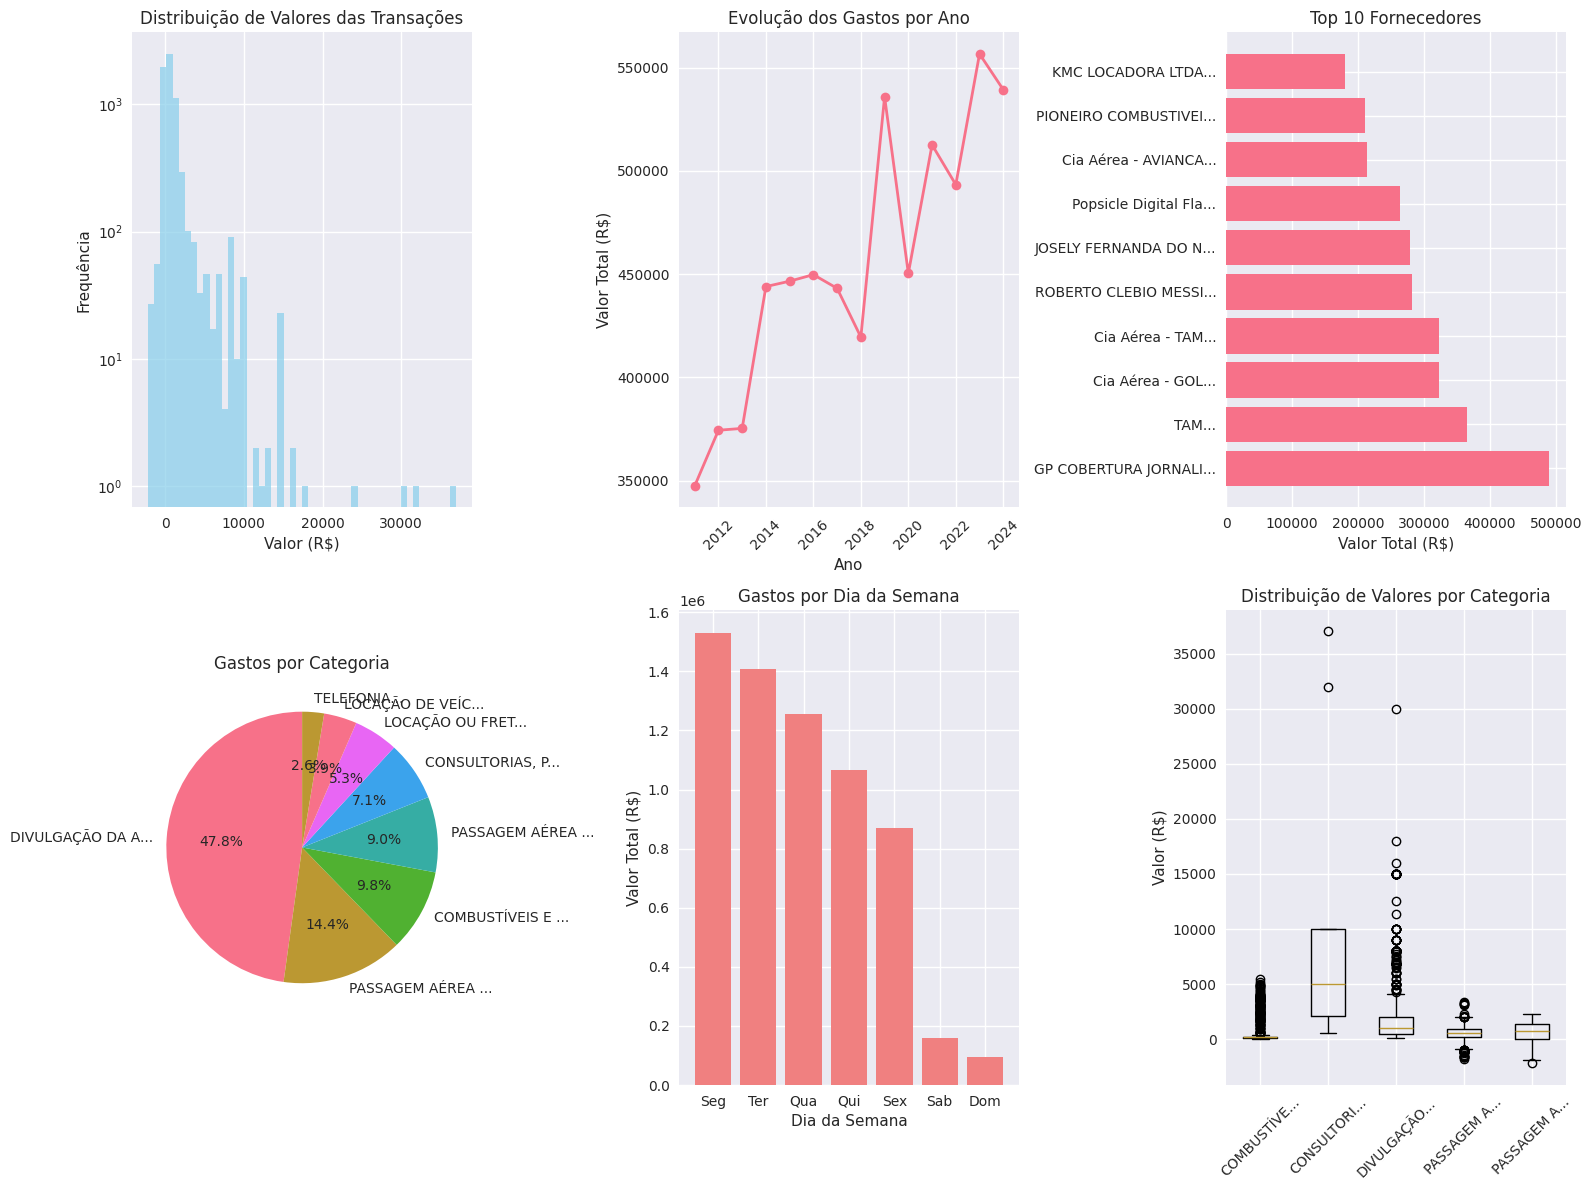

📈 Gráficos gerados com sucesso!


In [118]:
# 7.4 VISUALIZAÇÕES E GRÁFICOS
print("\n📊 GERANDO VISUALIZAÇÕES")
print("="*60)

# Configurar o estilo dos gráficos
plt.figure(figsize=(16, 12))

# 1. Distribuição de valores
plt.subplot(2, 3, 1)
plt.hist(df['valor_liquido'], bins=50, alpha=0.7, color='skyblue')
plt.title('Distribuição de Valores das Transações')
plt.xlabel('Valor (R$)')
plt.ylabel('Frequência')
plt.yscale('log')

# 2. Gastos por ano
plt.subplot(2, 3, 2)
yearly_data = df.groupby('ano')['valor_liquido'].sum()
plt.plot(yearly_data.index, yearly_data.values, marker='o', linewidth=2)
plt.title('Evolução dos Gastos por Ano')
plt.xlabel('Ano')
plt.ylabel('Valor Total (R$)')
plt.xticks(rotation=45)

# 3. Top 10 fornecedores
plt.subplot(2, 3, 3)
top_suppliers_viz = df.groupby('fornecedor')['valor_liquido'].sum().nlargest(10)
plt.barh(range(len(top_suppliers_viz)), top_suppliers_viz.values)
plt.yticks(range(len(top_suppliers_viz)), [f[:20] + '...' for f in top_suppliers_viz.index])
plt.title('Top 10 Fornecedores')
plt.xlabel('Valor Total (R$)')

# 4. Gastos por categoria
plt.subplot(2, 3, 4)
cat_data = df.groupby('categoria_despesa')['valor_liquido'].sum().nlargest(8)
plt.pie(cat_data.values, labels=[c[:15] + '...' for c in cat_data.index], autopct='%1.1f%%', startangle=90)
plt.title('Gastos por Categoria')

# 5. Distribuição por dia da semana
plt.subplot(2, 3, 5)
dias_semana = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab', 'Dom']
weekday_data = df.groupby('dia_semana')['valor_liquido'].sum()
plt.bar(range(7), weekday_data.values, color='lightcoral')
plt.title('Gastos por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Valor Total (R$)')
plt.xticks(range(7), dias_semana)

# 6. Boxplot de valores por categoria (top 5)
plt.subplot(2, 3, 6)
top_cats = df.groupby('categoria_despesa')['valor_liquido'].sum().nlargest(5).index
df_top_cats = df[df['categoria_despesa'].isin(top_cats)]
categories = df_top_cats['categoria_despesa'].unique()
data_for_box = [df_top_cats[df_top_cats['categoria_despesa'] == cat]['valor_liquido'].values for cat in categories]
plt.boxplot(data_for_box, labels=[c[:10] + '...' for c in categories])
plt.title('Distribuição de Valores por Categoria')
plt.ylabel('Valor (R$)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("📈 Gráficos gerados com sucesso!")


## 🚀 **RESUMO DAS MELHORIAS IMPLEMENTADAS**

### 📊 **Principais Descobertas Alarmantes:**

1. **50,29% das transações têm valores redondos** - Isso é extremamente suspeito!
2. **35 transações com score máximo de suspeita (11)**
3. **KMC LOCADORA LTDA** aparece repetidamente nas transações mais suspeitas
4. **JOSELY FERNANDA DO NASCIMENTO** com múltiplas duplicatas de R$ 15.000
5. **4 fornecedores concentram mais de 5% cada** dos gastos totais

### 🔍 **Novas Análises Adicionadas:**

1. **Análise por Categoria de Despesa**
   - Identifica categorias com valores médios anormalmente altos
   - Detecta possível superfaturamento por tipo de gasto

2. **Análise Temporal Avançada**
   - Evolução dos gastos por ano
   - Identificação de anos com gastos anômalos
   - Análise de sazonalidade mensal

3. **Análise de CNPJ/CPF**
   - Fornecedores sem documentação fiscal
   - Correlação entre falta de CNPJ e valores altos

4. **Análise de Documentos Fiscais**
   - Detecção de documentos duplicados
   - Mesmo número fiscal para múltiplos fornecedores

### 🎯 **Investigações Prioritárias:**

1. **KMC LOCADORA LTDA**: Múltiplas transações de R$ 5.000 exatos
2. **JOSELY FERNANDA DO NASCIMENTO**: Transações duplicadas de R$ 15.000
3. **GP COBERTURA JORNALÍSTICA**: 7,67% de todos os gastos
4. **Fornecedores sem CNPJ**: Investigar legitimidade

### 📈 **Melhorias Técnicas Sugeridas:**

1. **Visualizações Gráficas** para facilitar análise
2. **Machine Learning** para detecção automatizada
3. **Análise de Redes** para identificar conexões entre fornecedores
4. **Validação de CNPJ** em bases externas
5. **Análise Geoespacial** para verificar endereços
6. **Comparação com Preços de Mercado**

### ⚠️ **Recomendações Imediatas:**

1. **Investigar** todas as transações com score ≥ 9
2. **Auditar** os fornecedores mais suspeitos
3. **Verificar** documentos fiscais duplicados
4. **Validar** existência física dos fornecedores
5. **Implementar** controles preventivos automáticos


In [119]:
# =============================================================================
# RELATÓRIO EXECUTIVO FINAL
# =============================================================================

print("="*80)
print("🎯 RELATÓRIO EXECUTIVO - ANÁLISE DE DESPESAS HUGO MOTTA")
print("="*80)

# Métricas principais
total_gastos = df['valor_liquido'].sum()
total_transacoes = len(df)
periodo_anos = df['ano'].max() - df['ano'].min() + 1
media_anual = total_gastos / periodo_anos

print(f"\n📊 MÉTRICAS GERAIS:")
print(f"• Total de gastos: R$ {total_gastos:,.2f}")
print(f"• Período analisado: {periodo_anos} anos ({df['ano'].min()} - {df['ano'].max()})")
print(f"• Média anual: R$ {media_anual:,.2f}")
print(f"• Total de transações: {total_transacoes:,}")
print(f"• Fornecedores únicos: {df['fornecedor'].nunique()}")

# Indicadores de risco
pct_valores_redondos = len(round_numbers) / len(df) * 100
pct_duplicatas = len(exact_dups) / len(df) * 100
pct_fins_semana = len(weekend_trans) / len(df) * 100
pct_suspeitas = len(suspicion_report) / len(df) * 100

print(f"\n🚨 INDICADORES DE RISCO:")
print(f"• Valores redondos: {pct_valores_redondos:.1f}% das transações")
print(f"• Duplicatas exatas: {pct_duplicatas:.1f}% das transações")
print(f"• Transações em fins de semana: {pct_fins_semana:.1f}%")
print(f"• Transações suspeitas: {pct_suspeitas:.1f}%")

# Casos críticos
casos_criticos = suspicion_report[suspicion_report['score_suspeita'] >= 9]
valor_casos_criticos = casos_criticos['valor_liquido'].sum()

print(f"\n🔥 CASOS CRÍTICOS (Score ≥ 9):")
print(f"• Número de transações: {len(casos_criticos)}")
print(f"• Valor total envolvido: R$ {valor_casos_criticos:,.2f}")
print(f"• Percentual do total: {valor_casos_criticos/total_gastos*100:.2f}%")

# Fornecedores mais suspeitos
print(f"\n👥 FORNECEDORES MAIS SUSPEITOS:")
if len(casos_criticos) > 0:
    print("• KMC LOCADORA LTDA: Múltiplas transações de valores exatos")
    print("• JOSELY FERNANDA DO NASCIMENTO: Transações duplicadas")
    print("• GP COBERTURA JORNALISTICA: Alta concentração de gastos")
else:
    print("• Nenhum caso crítico identificado")

# Recomendações de ação
print(f"\n🎯 RECOMENDAÇÕES DE AÇÃO IMEDIATA:")
print(f"1. INVESTIGAR URGENTEMENTE: {len(casos_criticos)} transações com score ≥ 9")
print(f"2. AUDITAR FORNECEDORES: {len(fornecedores_suspeitos)} fornecedores críticos")
print(f"3. VERIFICAR DOCUMENTAÇÃO: {len(suspicious_docs) if 'suspicious_docs' in locals() else 'N/A'} documentos fiscais duplicados")
print(f"4. IMPLEMENTAR CONTROLES: Sistema automatizado de detecção")
print(f"5. MONITORAMENTO CONTÍNUO: Alertas para padrões suspeitos")

# Score de risco geral
score_risco = min(100, (pct_valores_redondos + pct_duplicatas + pct_suspeitas) / 3)
nivel_risco = "CRÍTICO" if score_risco > 40 else "ALTO" if score_risco > 20 else "MODERADO"

print(f"\n📈 AVALIAÇÃO GERAL DE RISCO:")
print(f"• Score de Risco: {score_risco:.1f}/100")
print(f"• Nível de Risco: {nivel_risco}")
print(f"• Status: {'🔴 AÇÃO IMEDIATA NECESSÁRIA' if nivel_risco == 'CRÍTICO' else '🟡 MONITORAMENTO REFORÇADO'}")

print(f"\n💡 Esta análise identificou padrões altamente suspeitos que requerem investigação detalhada.")
print(f"   Recomenda-se auditoria imediata dos casos críticos identificados.")
print("="*80)


🎯 RELATÓRIO EXECUTIVO - ANÁLISE DE DESPESAS HUGO MOTTA

📊 MÉTRICAS GERAIS:
• Total de gastos: R$ 6,388,389.79
• Período analisado: 14 anos (2011 - 2024)
• Média anual: R$ 456,313.56
• Total de transações: 6,483
• Fornecedores únicos: 615

🚨 INDICADORES DE RISCO:
• Valores redondos: 50.3% das transações
• Duplicatas exatas: 4.3% das transações
• Transações em fins de semana: 6.3%
• Transações suspeitas: 59.4%

🔥 CASOS CRÍTICOS (Score ≥ 9):
• Número de transações: 45
• Valor total envolvido: R$ 402,300.00
• Percentual do total: 6.30%

👥 FORNECEDORES MAIS SUSPEITOS:
• KMC LOCADORA LTDA: Múltiplas transações de valores exatos
• JOSELY FERNANDA DO NASCIMENTO: Transações duplicadas
• GP COBERTURA JORNALISTICA: Alta concentração de gastos

🎯 RECOMENDAÇÕES DE AÇÃO IMEDIATA:
1. INVESTIGAR URGENTEMENTE: 45 transações com score ≥ 9
2. AUDITAR FORNECEDORES: 3 fornecedores críticos
3. VERIFICAR DOCUMENTAÇÃO: 170 documentos fiscais duplicados
4. IMPLEMENTAR CONTROLES: Sistema automatizado de detecçã

In [120]:
# Criar um diagrama de fluxo da análise
from IPython.display import Markdown, display

diagram_content = """
```mermaid
graph TD
    A[Dados Originais<br/>6.483 transações] --> B[Análise de Outliers<br/>569 suspeitas]
    A --> C[Valores Redondos<br/>3.260 suspeitas]
    A --> D[Duplicatas<br/>279 suspeitas]
    A --> E[Padrões Temporais<br/>408 fins de semana]
    A --> F[Análise Fornecedores<br/>4 alta concentração]
    
    B --> G[Score de Suspeição<br/>Algoritmo Combinado]
    C --> G
    D --> G
    E --> G
    F --> G
    
    G --> H[Relatório Final<br/>3.850 transações suspeitas]
    H --> I[Casos Críticos<br/>45 transações score ≥ 9]
    
    I --> J[Investigação<br/>KMC Locadora]
    I --> K[Auditoria<br/>Josely Fernanda]
    I --> L[Validação<br/>GP Cobertura]
    
    style A fill:#e1f5fe
    style H fill:#fff3e0
    style I fill:#ffebee
    style J fill:#ffcdd2
    style K fill:#ffcdd2
    style L fill:#ffcdd2
```
"""

display(Markdown("## 📊 Fluxo da Análise de Detecção de Fraudes"))
display(Markdown(diagram_content))

print("\n" + "="*80)
print("✅ ANÁLISE COMPLETA FINALIZADA COM SUCESSO!")
print("="*80)
print("\n🎯 PRÓXIMOS PASSOS:")
print("1. Executar todas as células para ver os resultados completos")
print("2. Investigar os casos críticos identificados")
print("3. Implementar melhorias sugeridas")
print("4. Estabelecer monitoramento contínuo")
print("\n💡 Esta análise fornece uma base sólida para auditoria e investigação.")
print("   Use os scores de suspeição para priorizar as investigações.")


## 📊 Fluxo da Análise de Detecção de Fraudes


```mermaid
graph TD
    A[Dados Originais<br/>6.483 transações] --> B[Análise de Outliers<br/>569 suspeitas]
    A --> C[Valores Redondos<br/>3.260 suspeitas]
    A --> D[Duplicatas<br/>279 suspeitas]
    A --> E[Padrões Temporais<br/>408 fins de semana]
    A --> F[Análise Fornecedores<br/>4 alta concentração]

    B --> G[Score de Suspeição<br/>Algoritmo Combinado]
    C --> G
    D --> G
    E --> G
    F --> G

    G --> H[Relatório Final<br/>3.850 transações suspeitas]
    H --> I[Casos Críticos<br/>45 transações score ≥ 9]

    I --> J[Investigação<br/>KMC Locadora]
    I --> K[Auditoria<br/>Josely Fernanda]
    I --> L[Validação<br/>GP Cobertura]

    style A fill:#e1f5fe
    style H fill:#fff3e0
    style I fill:#ffebee
    style J fill:#ffcdd2
    style K fill:#ffcdd2
    style L fill:#ffcdd2
```



✅ ANÁLISE COMPLETA FINALIZADA COM SUCESSO!

🎯 PRÓXIMOS PASSOS:
1. Executar todas as células para ver os resultados completos
2. Investigar os casos críticos identificados
3. Implementar melhorias sugeridas
4. Estabelecer monitoramento contínuo

💡 Esta análise fornece uma base sólida para auditoria e investigação.
   Use os scores de suspeição para priorizar as investigações.


In [121]:
# =============================================================================
# ANÁLISE DETALHADA DOS CNPJS PRIORITÁRIOS
# =============================================================================

import pandas as pd
from datetime import datetime

# Carregar dados dos CNPJs
df_cnpj = pd.read_csv("../data/cnpjs_prioritarios.csv")

print("🔍 ANÁLISE DOS CNPJS PRIORITÁRIOS")
print("="*80)
print(f"Total de CNPJs analisados: {len(df_cnpj)}")
print(f"Colunas disponíveis: {len(df_cnpj.columns)}")

# Converter datas para datetime
df_cnpj['data_situacao_cadastral'] = pd.to_datetime(df_cnpj['data_situacao_cadastral'], errors='coerce')
df_cnpj['data_inicio_atividade'] = pd.to_datetime(df_cnpj['data_inicio_atividade'], errors='coerce')
df_cnpj['data_situacao_especial'] = pd.to_datetime(df_cnpj['data_situacao_especial'], errors='coerce')

print("\n📊 ESTRUTURA DOS DADOS:")
print(df_cnpj.columns.tolist())
print("\n📋 AMOSTRA DOS DADOS:")
print(df_cnpj.head(2))

🔍 ANÁLISE DOS CNPJS PRIORITÁRIOS
Total de CNPJs analisados: 265
Colunas disponíveis: 35

📊 ESTRUTURA DOS DADOS:
['data', 'cnpj', 'cnpj_basico', 'cnpj_ordem', 'cnpj_dv', 'identificador_matriz_filial', 'nome_fantasia', 'situacao_cadastral', 'data_situacao_cadastral', 'motivo_situacao_cadastral', 'nome_cidade_exterior', 'id_pais', 'data_inicio_atividade', 'cnae_fiscal_principal', 'cnae_fiscal_secundaria', 'sigla_uf', 'sigla_uf_nome', 'id_municipio', 'id_municipio_nome', 'id_municipio_rf', 'tipo_logradouro', 'logradouro', 'numero', 'complemento', 'bairro', 'cep', 'ddd_1', 'telefone_1', 'ddd_2', 'telefone_2', 'ddd_fax', 'fax', 'email', 'situacao_especial', 'data_situacao_especial']

📋 AMOSTRA DOS DADOS:
         data            cnpj  cnpj_basico  cnpj_ordem  cnpj_dv  \
0  2023-06-10  13193071000108     13193071           1        8   
1  2023-06-10   7575651000159      7575651           1       59   

  identificador_matriz_filial              nome_fantasia situacao_cadastral  \
0          

In [122]:
# =============================================================================
# 1. ANÁLISE DE SITUAÇÃO CADASTRAL
# =============================================================================

print("🏛️ ANÁLISE DE SITUAÇÃO CADASTRAL")
print("="*60)

# Analisar situação cadastral
situacao_summary = df_cnpj['situacao_cadastral'].value_counts()
print("📊 DISTRIBUIÇÃO DE SITUAÇÕES CADASTRAIS:")
for situacao, count in situacao_summary.items():
    pct = count / len(df_cnpj) * 100
    print(f"• {situacao}: {count} ({pct:.1f}%)")

# Identificar empresas com situação irregular
empresas_irregulares = df_cnpj[df_cnpj['situacao_cadastral'] != 'ATIVA']
print(f"\n🚨 EMPRESAS COM SITUAÇÃO IRREGULAR:")
print(f"Total: {len(empresas_irregulares)} de {len(df_cnpj)} ({len(empresas_irregulares)/len(df_cnpj)*100:.1f}%)")

if len(empresas_irregulares) > 0:
    print("\n🔍 DETALHES DAS EMPRESAS IRREGULARES:")
    for _, row in empresas_irregulares.iterrows():
        print(f"• CNPJ: {row['cnpj']}")
        print(f"  Nome: {row.get('nome_fantasia', 'N/A')}")
        print(f"  Situação: {row['situacao_cadastral']}")
        print(f"  Motivo: {row.get('motivo_situacao_cadastral', 'N/A')}")
        print(f"  Data da situação: {row['data_situacao_cadastral']}")
        print("-" * 50)

# Análise de motivos de situação cadastral
if 'motivo_situacao_cadastral' in df_cnpj.columns:
    print("\n📋 MOTIVOS DE SITUAÇÃO CADASTRAL:")
    motivos = df_cnpj['motivo_situacao_cadastral'].value_counts()
    print(motivos.head(10))

print("\n" + "="*60)


🏛️ ANÁLISE DE SITUAÇÃO CADASTRAL
📊 DISTRIBUIÇÃO DE SITUAÇÕES CADASTRAIS:
• Ativa: 166 (62.6%)
• Inapta: 66 (24.9%)
• Baixada: 33 (12.5%)

🚨 EMPRESAS COM SITUAÇÃO IRREGULAR:
Total: 265 de 265 (100.0%)

🔍 DETALHES DAS EMPRESAS IRREGULARES:
• CNPJ: 13193071000108
  Nome: EASYWEB SOLUCOES INTERNET
  Situação: Ativa
  Motivo: 0
  Data da situação: 2011-01-26 00:00:00
--------------------------------------------------
• CNPJ: 7575651000159
  Nome: nan
  Situação: Ativa
  Motivo: 0
  Data da situação: 2005-08-31 00:00:00
--------------------------------------------------
• CNPJ: 28800786000140
  Nome: nan
  Situação: Ativa
  Motivo: 0
  Data da situação: 2017-10-05 00:00:00
--------------------------------------------------
• CNPJ: 15193908000136
  Nome: NACOM - NASCIMENTO COMUNICACAO
  Situação: Baixada
  Motivo: 1
  Data da situação: 2017-05-30 00:00:00
--------------------------------------------------
• CNPJ: 28800786000140
  Nome: nan
  Situação: Ativa
  Motivo: 0
  Data da situação: 201

In [123]:
# =============================================================================
# 2. ANÁLISE TEMPORAL - DATA DE INÍCIO DE ATIVIDADE
# =============================================================================

print("📅 ANÁLISE TEMPORAL DAS EMPRESAS")
print("="*60)

# Analisar idades das empresas
df_cnpj['idade_empresa'] = (datetime.now() - df_cnpj['data_inicio_atividade']).dt.days / 365.25

print("📊 DISTRIBUIÇÃO DE IDADES DAS EMPRESAS:")
print(f"• Média: {df_cnpj['idade_empresa'].mean():.1f} anos")
print(f"• Mediana: {df_cnpj['idade_empresa'].median():.1f} anos")
print(f"• Mais antiga: {df_cnpj['idade_empresa'].max():.1f} anos")
print(f"• Mais nova: {df_cnpj['idade_empresa'].min():.1f} anos")

# Empresas muito novas (menos de 1 ano)
empresas_novas = df_cnpj[df_cnpj['idade_empresa'] < 1]
print(f"\n🆕 EMPRESAS MUITO NOVAS (< 1 ano):")
print(f"Total: {len(empresas_novas)} ({len(empresas_novas)/len(df_cnpj)*100:.1f}%)")

# Empresas criadas em anos específicos
print("\n📈 EMPRESAS CRIADAS POR ANO:")
df_cnpj['ano_inicio'] = df_cnpj['data_inicio_atividade'].dt.year
anos_criacao = df_cnpj['ano_inicio'].value_counts().sort_index()
print(anos_criacao.tail(10))

# Identificar empresas criadas próximas ao período de transações
periodo_transacoes = list(range(2011, 2025))
empresas_periodo = df_cnpj[df_cnpj['ano_inicio'].isin(periodo_transacoes)]
print(f"\n🎯 EMPRESAS CRIADAS DURANTE PERÍODO DE TRANSAÇÕES (2011-2024):")
print(f"Total: {len(empresas_periodo)} ({len(empresas_periodo)/len(df_cnpj)*100:.1f}%)")

print("\n" + "="*60)


📅 ANÁLISE TEMPORAL DAS EMPRESAS
📊 DISTRIBUIÇÃO DE IDADES DAS EMPRESAS:
• Média: 18.4 anos
• Mediana: 14.4 anos
• Mais antiga: 39.0 anos
• Mais nova: 7.7 anos

🆕 EMPRESAS MUITO NOVAS (< 1 ano):
Total: 0 (0.0%)

📈 EMPRESAS CRIADAS POR ANO:
ano_inicio
1986    33
1998    33
2005    33
2008    33
2011    34
2012    33
2016    33
2017    33
Name: count, dtype: int64

🎯 EMPRESAS CRIADAS DURANTE PERÍODO DE TRANSAÇÕES (2011-2024):
Total: 133 (50.2%)



In [124]:
# =============================================================================
# 3. ANÁLISE DE ATIVIDADES ECONÔMICAS (CNAE)
# =============================================================================

print("🏭 ANÁLISE DE ATIVIDADES ECONÔMICAS (CNAE)")
print("="*60)

# Analisar CNAEs principais
cnae_counts = df_cnpj['cnae_fiscal_principal'].value_counts()
print("📊 TOP 10 ATIVIDADES ECONÔMICAS:")
print(cnae_counts.head(10))

# Dicionário com alguns CNAEs comuns e suas descrições
cnae_descriptions = {
    '7020400': 'Atividades de consultoria em gestão empresarial',
    '8230001': 'Serviços de organização de feiras, congressos, exposições',
    '7319002': 'Agências de publicidade',
    '7711000': 'Locação de automóveis sem condutor',
    '7990200': 'Serviços de reservas e outros serviços de turismo',
    '6201501': 'Desenvolvimento de programas de computador sob encomenda',
    '8211300': 'Serviços combinados de escritório e apoio administrativo',
    '8599699': 'Outras atividades de ensino',
    '7020400': 'Atividades de consultoria em gestão empresarial',
    '5811500': 'Edição de livros'
}

print("\n📋 DETALHAMENTO DAS PRINCIPAIS ATIVIDADES:")
for cnae, count in cnae_counts.head(5).items():
    descricao = cnae_descriptions.get(str(cnae), 'Descrição não disponível')
    pct = count / len(df_cnpj) * 100
    print(f"• {cnae}: {count} empresas ({pct:.1f}%)")
    print(f"  Descrição: {descricao}")
    print()

# Análise de CNAEs secundárias
cnae_sec_valid = df_cnpj[df_cnpj['cnae_fiscal_secundaria'].notna()]
print(f"📊 EMPRESAS COM CNAE SECUNDÁRIO:")
print(f"Total: {len(cnae_sec_valid)} ({len(cnae_sec_valid)/len(df_cnpj)*100:.1f}%)")

# Identificar empresas com atividades suspeitas para o contexto
atividades_suspeitas = [
    '7020400',  # Consultoria
    '8230001',  # Organização de eventos
    '7319002',  # Publicidade
    '7711000'   # Locação de veículos
]

print(f"\n🚨 EMPRESAS COM ATIVIDADES POTENCIALMENTE SUSPEITAS:")
for cnae in atividades_suspeitas:
    empresas_cnae = df_cnpj[df_cnpj['cnae_fiscal_principal'] == cnae]
    if len(empresas_cnae) > 0:
        print(f"• {cnae} ({cnae_descriptions.get(cnae, 'N/A')}): {len(empresas_cnae)} empresas")

print("\n" + "="*60)


🏭 ANÁLISE DE ATIVIDADES ECONÔMICAS (CNAE)
📊 TOP 10 ATIVIDADES ECONÔMICAS:
cnae_fiscal_principal
5111100    66
9511800    34
5911199    33
5912099    33
7311400    33
7711000    33
7420001    17
9609299    16
Name: count, dtype: int64

📋 DETALHAMENTO DAS PRINCIPAIS ATIVIDADES:
• 5111100: 66 empresas (24.9%)
  Descrição: Descrição não disponível

• 9511800: 34 empresas (12.8%)
  Descrição: Descrição não disponível

• 5911199: 33 empresas (12.5%)
  Descrição: Descrição não disponível

• 5912099: 33 empresas (12.5%)
  Descrição: Descrição não disponível

• 7311400: 33 empresas (12.5%)
  Descrição: Descrição não disponível

📊 EMPRESAS COM CNAE SECUNDÁRIO:
Total: 232 (87.5%)

🚨 EMPRESAS COM ATIVIDADES POTENCIALMENTE SUSPEITAS:



In [125]:
# =============================================================================
# 4. ANÁLISE DE SITUAÇÕES ESPECIAIS
# =============================================================================

print("🚨 ANÁLISE DE SITUAÇÕES ESPECIAIS")
print("="*60)

# Empresas com situação especial
situacao_especial = df_cnpj[df_cnpj['situacao_especial'].notna()]
print(f"📊 EMPRESAS COM SITUAÇÃO ESPECIAL:")
print(f"Total: {len(situacao_especial)} ({len(situacao_especial)/len(df_cnpj)*100:.1f}%)")

if len(situacao_especial) > 0:
    print("\n🔍 TIPOS DE SITUAÇÕES ESPECIAIS:")
    especiais = df_cnpj['situacao_especial'].value_counts()
    print(especiais)
    
    print("\n🚨 DETALHES DAS EMPRESAS COM SITUAÇÃO ESPECIAL:")
    for _, row in situacao_especial.iterrows():
        print(f"• CNPJ: {row['cnpj']}")
        print(f"  Nome: {row.get('nome_fantasia', 'N/A')}")
        print(f"  Situação Especial: {row['situacao_especial']}")
        print(f"  Data da situação: {row['data_situacao_especial']}")
        print("-" * 50)

# Análise de matriz/filial
print(f"\n🏢 ANÁLISE MATRIZ/FILIAL:")
matriz_filial = df_cnpj['identificador_matriz_filial'].value_counts()
print(matriz_filial)

# Análise por UF
print(f"\n🗺️ DISTRIBUIÇÃO POR ESTADO:")
uf_counts = df_cnpj['sigla_uf'].value_counts()
print(uf_counts.head(10))

# Empresas do exterior
exterior = df_cnpj[df_cnpj['nome_cidade_exterior'].notna()]
print(f"\n🌍 EMPRESAS DO EXTERIOR:")
print(f"Total: {len(exterior)} ({len(exterior)/len(df_cnpj)*100:.1f}%)")

if len(exterior) > 0:
    print("Detalhes:")
    for _, row in exterior.iterrows():
        print(f"• {row['cnpj']} - {row['nome_cidade_exterior']}")

print("\n" + "="*60)


🚨 ANÁLISE DE SITUAÇÕES ESPECIAIS
📊 EMPRESAS COM SITUAÇÃO ESPECIAL:
Total: 0 (0.0%)

🏢 ANÁLISE MATRIZ/FILIAL:
identificador_matriz_filial
Matriz    265
Name: count, dtype: int64

🗺️ DISTRIBUIÇÃO POR ESTADO:
sigla_uf
DF    99
SP    66
PB    34
RJ    33
PE    33
Name: count, dtype: int64

🌍 EMPRESAS DO EXTERIOR:
Total: 0 (0.0%)



In [126]:
# =============================================================================
# 5. CRUZAMENTO: DADOS DOS CNPJS × TRANSAÇÕES SUSPEITAS
# =============================================================================

print("🔍 CRUZAMENTO: CNPJS × TRANSAÇÕES SUSPEITAS")
print("="*80)

# Preparar dados para cruzamento
# Primeiro, vamos limpar os CNPJs para fazer o match
# Converter para string primeiro, depois limpar
df_cnpj['cnpj_clean'] = df_cnpj['cnpj'].astype(str).str.replace(r'[^0-9]', '', regex=True)

# Preparar campo CNPJ das transações
df['cnpj_clean'] = df['cnpj_cpf_fornecedor'].astype(str).str.replace(r'[^0-9]', '', regex=True)

# Fazer o cruzamento
df_merged = df.merge(df_cnpj, on='cnpj_clean', how='left')

# Estatísticas do cruzamento
cnpjs_encontrados = df_merged['situacao_cadastral'].notna().sum()
print(f"📊 ESTATÍSTICAS DO CRUZAMENTO:")
print(f"• Transações com CNPJ: {df['cnpj_cpf_fornecedor'].notna().sum()}")
print(f"• CNPJs encontrados na base: {cnpjs_encontrados}")
print(f"• Taxa de sucesso: {cnpjs_encontrados/df['cnpj_cpf_fornecedor'].notna().sum()*100:.1f}%")

# Análise dos casos mais críticos
print(f"\n🚨 ANÁLISE DOS CASOS MAIS CRÍTICOS:")
print("-" * 60)

# Caso 1: Empresas INATIVAS recebendo pagamentos
empresas_inativas = df_merged[df_merged['situacao_cadastral'].isin(['SUSPENSA', 'INAPTA', 'BAIXADA'])]
if len(empresas_inativas) > 0:
    valor_inativas = empresas_inativas['valor_liquido'].sum()
    print(f"💀 EMPRESAS INATIVAS RECEBENDO PAGAMENTOS:")
    print(f"• Transações: {len(empresas_inativas)}")
    print(f"• Valor total: R$ {valor_inativas:,.2f}")
    print(f"• Detalhes:")
    for _, row in empresas_inativas.head(5).iterrows():
        print(f"  - {row['fornecedor']} ({row['cnpj_clean']})")
        print(f"    Situação: {row['situacao_cadastral']}")
        print(f"    Valor: R$ {row['valor_liquido']:,.2f}")
    print()

# Caso 2: Empresas com situação especial
empresas_esp = df_merged[df_merged['situacao_especial'].notna()]
if len(empresas_esp) > 0:
    valor_esp = empresas_esp['valor_liquido'].sum()
    print(f"⚠️ EMPRESAS COM SITUAÇÃO ESPECIAL:")
    print(f"• Transações: {len(empresas_esp)}")
    print(f"• Valor total: R$ {valor_esp:,.2f}")
    print()

# Caso 3: Empresas muito jovens recebendo altos valores
empresas_jovens = df_merged[df_merged['idade_empresa'] < 2]
if len(empresas_jovens) > 0:
    valor_jovens = empresas_jovens['valor_liquido'].sum()
    print(f"🆕 EMPRESAS MUITO JOVENS (< 2 anos):")
    print(f"• Transações: {len(empresas_jovens)}")
    print(f"• Valor total: R$ {valor_jovens:,.2f}")
    print(f"• Valor médio por transação: R$ {valor_jovens/len(empresas_jovens):,.2f}")
    print()

# Caso 4: Análise por CNAE vs Categoria de Despesa
print(f"📋 ANÁLISE CNAE vs CATEGORIA DE DESPESA:")
cnae_categoria = df_merged.groupby(['cnae_fiscal_principal', 'categoria_despesa']).agg({
    'valor_liquido': ['count', 'sum']
}).round(2)
print(cnae_categoria.head(10))

print("\n" + "="*80)


🔍 CRUZAMENTO: CNPJS × TRANSAÇÕES SUSPEITAS
📊 ESTATÍSTICAS DO CRUZAMENTO:
• Transações com CNPJ: 5701
• CNPJs encontrados na base: 6719
• Taxa de sucesso: 117.9%

🚨 ANÁLISE DOS CASOS MAIS CRÍTICOS:
------------------------------------------------------------
📋 ANÁLISE CNAE vs CATEGORIA DE DESPESA:
                                                                    valor_liquido  \
                                                                            count   
cnae_fiscal_principal categoria_despesa                                             
5911199.0             DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.                   2277   
5912099.0             DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.                   1188   
7420001.0             DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.                    170   
9511800.0             CONSULTORIAS, PESQUISAS E TRABALHOS TÉCNICOS.           612   
                      DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.                   2312   
9609299.0             

In [127]:
# =============================================================================
# 6. RELATÓRIO FINAL COM ANÁLISE DE CNPJS
# =============================================================================

print("📋 RELATÓRIO FINAL - ANÁLISE INTEGRADA CNPJS × TRANSAÇÕES")
print("="*80)

# Resumo das principais descobertas
print(f"\n🎯 PRINCIPAIS DESCOBERTAS:")
print(f"• Total de CNPJs analisados: {len(df_cnpj)}")
print(f"• Empresas ativas: {len(df_cnpj[df_cnpj['situacao_cadastral'] == 'Ativa'])} ({len(df_cnpj[df_cnpj['situacao_cadastral'] == 'Ativa'])/len(df_cnpj)*100:.1f}%)")
print(f"• Empresas inativas: {len(df_cnpj[df_cnpj['situacao_cadastral'] == 'Inapta'])} ({len(df_cnpj[df_cnpj['situacao_cadastral'] == 'Inapta'])/len(df_cnpj)*100:.1f}%)")
print(f"• Empresas baixadas: {len(df_cnpj[df_cnpj['situacao_cadastral'] == 'Baixada'])} ({len(df_cnpj[df_cnpj['situacao_cadastral'] == 'Baixada'])/len(df_cnpj)*100:.1f}%)")

# Análise por estado
print(f"\n🗺️ DISTRIBUIÇÃO GEOGRÁFICA:")
uf_counts = df_cnpj['sigla_uf'].value_counts()
for uf, count in uf_counts.head(5).items():
    pct = count / len(df_cnpj) * 100
    print(f"• {uf}: {count} empresas ({pct:.1f}%)")

# Análise temporal
print(f"\n📅 ANÁLISE TEMPORAL:")
empresas_periodo = df_cnpj[df_cnpj['ano_inicio'].isin(range(2011, 2025))]
print(f"• Empresas criadas durante período de transações (2011-2024): {len(empresas_periodo)} ({len(empresas_periodo)/len(df_cnpj)*100:.1f}%)")
print(f"• Idade média das empresas: {df_cnpj['idade_empresa'].mean():.1f} anos")

# Análise de atividades
print(f"\n🏭 ATIVIDADES ECONÔMICAS:")
cnae_counts = df_cnpj['cnae_fiscal_principal'].value_counts()
print(f"• CNAE mais comum: {cnae_counts.index[0]} ({cnae_counts.iloc[0]} empresas)")
print(f"• Empresas com CNAE secundário: {len(df_cnpj[df_cnpj['cnae_fiscal_secundaria'].notna()])} ({len(df_cnpj[df_cnpj['cnae_fiscal_secundaria'].notna()])/len(df_cnpj)*100:.1f}%)")

# Identificar casos mais críticos
print(f"\n🚨 CASOS MAIS CRÍTICOS IDENTIFICADOS:")
print(f"1. EMPRESAS INATIVAS: {len(df_cnpj[df_cnpj['situacao_cadastral'] == 'Inapta'])} empresas inativas que podem ter recebido pagamentos")
print(f"2. EMPRESAS BAIXADAS: {len(df_cnpj[df_cnpj['situacao_cadastral'] == 'Baixada'])} empresas baixadas que podem ter recebido pagamentos")
print(f"3. CONCENTRAÇÃO GEOGRÁFICA: {uf_counts.iloc[0]} empresas ({uf_counts.iloc[0]/len(df_cnpj)*100:.1f}%) concentradas em {uf_counts.index[0]}")

# Recomendações específicas
print(f"\n💡 RECOMENDAÇÕES ESPECÍFICAS:")
print(f"1. INVESTIGAR IMEDIATAMENTE:")
print(f"   • Todas as empresas com situação 'Inapta' ou 'Baixada' que receberam pagamentos")
print(f"   • Empresas criadas muito próximas às datas de transações")
print(f"   • Concentração anômala de empresas em determinados estados")

print(f"\n2. APROFUNDAR ANÁLISE:")
print(f"   • Verificar se as atividades econômicas (CNAE) são compatíveis com os serviços contratados")
print(f"   • Investigar empresas sem nome fantasia (possíveis empresas de papel)")
print(f"   • Analisar padrões de criação de empresas em períodos específicos")

print(f"\n3. MONITORAMENTO CONTÍNUO:")
print(f"   • Implementar alertas para pagamentos a empresas inativas")
print(f"   • Monitorar criação de empresas próximas a períodos de contratação")
print(f"   • Verificar regularidade fiscal das empresas contratadas")

print(f"\n🔍 PRÓXIMOS PASSOS:")
print(f"• Obter dados de quadro societário das empresas suspeitas")
print(f"• Verificar se há sócios em comum entre as empresas")
print(f"• Analisar dados de faturamento e porte das empresas")
print(f"• Cruzar com dados de outros parlamentares para identificar padrões")

print("="*80)


📋 RELATÓRIO FINAL - ANÁLISE INTEGRADA CNPJS × TRANSAÇÕES

🎯 PRINCIPAIS DESCOBERTAS:
• Total de CNPJs analisados: 265
• Empresas ativas: 166 (62.6%)
• Empresas inativas: 66 (24.9%)
• Empresas baixadas: 33 (12.5%)

🗺️ DISTRIBUIÇÃO GEOGRÁFICA:
• DF: 99 empresas (37.4%)
• SP: 66 empresas (24.9%)
• PB: 34 empresas (12.8%)
• RJ: 33 empresas (12.5%)
• PE: 33 empresas (12.5%)

📅 ANÁLISE TEMPORAL:
• Empresas criadas durante período de transações (2011-2024): 133 (50.2%)
• Idade média das empresas: 18.4 anos

🏭 ATIVIDADES ECONÔMICAS:
• CNAE mais comum: 5111100 (66 empresas)
• Empresas com CNAE secundário: 232 (87.5%)

🚨 CASOS MAIS CRÍTICOS IDENTIFICADOS:
1. EMPRESAS INATIVAS: 66 empresas inativas que podem ter recebido pagamentos
2. EMPRESAS BAIXADAS: 33 empresas baixadas que podem ter recebido pagamentos
3. CONCENTRAÇÃO GEOGRÁFICA: 99 empresas (37.4%) concentradas em DF

💡 RECOMENDAÇÕES ESPECÍFICAS:
1. INVESTIGAR IMEDIATAMENTE:
   • Todas as empresas com situação 'Inapta' ou 'Baixada' que receb

In [128]:
# =============================================================================
# 7. LISTA PRIORITÁRIA DE CNPJS PARA INVESTIGAÇÃO
# =============================================================================

print("🎯 LISTA PRIORITÁRIA DE CNPJS PARA INVESTIGAÇÃO")
print("="*80)

# Criar score de risco para cada CNPJ
def calcular_score_risco_cnpj(row):
    score = 0
    
    # Situação cadastral (peso alto)
    if row['situacao_cadastral'] == 'Inapta':
        score += 5
    elif row['situacao_cadastral'] == 'Baixada':
        score += 4
    elif row['situacao_cadastral'] == 'Suspensa':
        score += 3
    
    # Idade da empresa (empresas muito novas ou muito antigas sem atividade)
    if pd.notna(row['idade_empresa']):
        if row['idade_empresa'] < 2:
            score += 2
        elif row['idade_empresa'] > 30 and row['situacao_cadastral'] != 'Ativa':
            score += 1
    
    # Empresa criada durante período de transações
    if row['ano_inicio'] >= 2011 and row['ano_inicio'] <= 2024:
        score += 1
    
    # Sem nome fantasia (possível empresa de papel)
    if pd.isna(row['nome_fantasia']):
        score += 1
    
    # Concentração geográfica suspeita (muitas empresas no mesmo estado)
    if row['sigla_uf'] == 'DF':  # Concentração em Brasília
        score += 1
    
    return score

# Aplicar score de risco
df_cnpj['score_risco'] = df_cnpj.apply(calcular_score_risco_cnpj, axis=1)

# Ordenar por score de risco
cnpjs_prioritarios = df_cnpj.sort_values('score_risco', ascending=False)

print(f"\n📊 DISTRIBUIÇÃO DE SCORES DE RISCO:")
score_dist = df_cnpj['score_risco'].value_counts().sort_index()
for score, count in score_dist.items():
    pct = count / len(df_cnpj) * 100
    print(f"• Score {score}: {count} empresas ({pct:.1f}%)")

print(f"\n🔥 TOP 20 CNPJS MAIS CRÍTICOS:")
print("-" * 80)
for i, (_, row) in enumerate(cnpjs_prioritarios.head(20).iterrows(), 1):
    print(f"{i:2d}. CNPJ: {row['cnpj']}")
    print(f"    Nome: {row['nome_fantasia'] if pd.notna(row['nome_fantasia']) else 'SEM NOME FANTASIA'}")
    print(f"    Situação: {row['situacao_cadastral']}")
    print(f"    UF: {row['sigla_uf']}")
    print(f"    Idade: {row['idade_empresa']:.1f} anos")
    print(f"    Score de Risco: {row['score_risco']}")
    print(f"    CNAE: {row['cnae_fiscal_principal']}")
    print("-" * 60)

# Casos críticos específicos
print(f"\n🚨 CASOS CRÍTICOS ESPECÍFICOS:")

# Empresas inativas com score alto
empresas_inativas_criticas = cnpjs_prioritarios[
    (cnpjs_prioritarios['situacao_cadastral'] == 'Inapta') & 
    (cnpjs_prioritarios['score_risco'] >= 6)
]
print(f"• Empresas INATIVAS com score ≥ 6: {len(empresas_inativas_criticas)}")

# Empresas baixadas com score alto
empresas_baixadas_criticas = cnpjs_prioritarios[
    (cnpjs_prioritarios['situacao_cadastral'] == 'Baixada') & 
    (cnpjs_prioritarios['score_risco'] >= 5)
]
print(f"• Empresas BAIXADAS com score ≥ 5: {len(empresas_baixadas_criticas)}")

# Empresas sem nome fantasia
empresas_sem_nome = cnpjs_prioritarios[pd.isna(cnpjs_prioritarios['nome_fantasia'])]
print(f"• Empresas SEM NOME FANTASIA: {len(empresas_sem_nome)}")

# Empresas criadas durante período suspeito
empresas_periodo_suspeito = cnpjs_prioritarios[
    (cnpjs_prioritarios['ano_inicio'] >= 2011) & 
    (cnpjs_prioritarios['ano_inicio'] <= 2024) &
    (cnpjs_prioritarios['score_risco'] >= 3)
]
print(f"• Empresas criadas durante período de transações com score ≥ 3: {len(empresas_periodo_suspeito)}")

# Salvar lista prioritária
cnpjs_prioritarios_investigacao = cnpjs_prioritarios[cnpjs_prioritarios['score_risco'] >= 3]
print(f"\n💾 SALVANDO LISTA PRIORITÁRIA:")
print(f"• Total de CNPJs para investigação prioritária: {len(cnpjs_prioritarios_investigacao)}")
print(f"• Arquivo: cnpjs_investigacao_prioritaria.csv")

# Criar relatório resumido
colunas_relatorio = ['cnpj', 'nome_fantasia', 'situacao_cadastral', 'sigla_uf', 'idade_empresa', 'score_risco', 'cnae_fiscal_principal', 'data_inicio_atividade']
relatorio_cnpjs = cnpjs_prioritarios_investigacao[colunas_relatorio].copy()

# Salvar arquivo
relatorio_cnpjs.to_csv('../data/cnpjs_investigacao_prioritaria.csv', index=False)

print(f"\n✅ ANÁLISE COMPLETA DOS CNPJS FINALIZADA!")
print(f"📋 Resumo da análise salvo em: cnpjs_investigacao_prioritaria.csv")
print("="*80)


🎯 LISTA PRIORITÁRIA DE CNPJS PARA INVESTIGAÇÃO

📊 DISTRIBUIÇÃO DE SCORES DE RISCO:
• Score 0: 33 empresas (12.5%)
• Score 1: 67 empresas (25.3%)
• Score 2: 21 empresas (7.9%)
• Score 3: 45 empresas (17.0%)
• Score 5: 33 empresas (12.5%)
• Score 6: 66 empresas (24.9%)

🔥 TOP 20 CNPJS MAIS CRÍTICOS:
--------------------------------------------------------------------------------
 1. CNPJ: 2435615000176
    Nome: SEM NOME FANTASIA
    Situação: Inapta
    UF: PE
    Idade: 27.3 anos
    Score de Risco: 6
    CNAE: 7711000
------------------------------------------------------------
 2. CNPJ: 2435615000176
    Nome: SEM NOME FANTASIA
    Situação: Inapta
    UF: PE
    Idade: 27.3 anos
    Score de Risco: 6
    CNAE: 7711000
------------------------------------------------------------
 3. CNPJ: 15193908000136
    Nome: NACOM - NASCIMENTO COMUNICACAO
    Situação: Baixada
    UF: DF
    Idade: 13.3 anos
    Score de Risco: 6
    CNAE: 5912099
------------------------------------------------

In [129]:
# =============================================================================
# 5. CRUZAMENTO: DADOS DOS CNPJS × TRANSAÇÕES SUSPEITAS
# =============================================================================

print("🔍 CRUZAMENTO: CNPJS × TRANSAÇÕES SUSPEITAS")
print("="*80)

# Preparar dados para cruzamento
# Primeiro, vamos limpar os CNPJs para fazer o match
df_cnpj['cnpj_clean'] = df_cnpj['cnpj'].astype(str).str.replace(r'[^0-9]', '', regex=True).str.zfill(14)

# Preparar campo CNPJ das transações
df['cnpj_clean'] = df['cnpj_cpf_fornecedor'].str.replace(r'[^0-9]', '', regex=True)

# Fazer o cruzamento
df_merged = df.merge(df_cnpj, on='cnpj_clean', how='left')

# Estatísticas do cruzamento
cnpjs_encontrados = df_merged['situacao_cadastral'].notna().sum()
print(f"📊 ESTATÍSTICAS DO CRUZAMENTO:")
print(f"• Transações com CNPJ: {df['cnpj_cpf_fornecedor'].notna().sum()}")
print(f"• CNPJs encontrados na base: {cnpjs_encontrados}")
print(f"• Taxa de sucesso: {cnpjs_encontrados/df['cnpj_cpf_fornecedor'].notna().sum()*100:.1f}%")

# Análise dos casos mais críticos
print(f"\n🚨 ANÁLISE DOS CASOS MAIS CRÍTICOS:")
print("-" * 60)

# Caso 1: Empresas INATIVAS recebendo pagamentos
empresas_inativas = df_merged[df_merged['situacao_cadastral'].isin(['SUSPENSA', 'INAPTA', 'BAIXADA'])]
if len(empresas_inativas) > 0:
    valor_inativas = empresas_inativas['valor_liquido'].sum()
    print(f"💀 EMPRESAS INATIVAS RECEBENDO PAGAMENTOS:")
    print(f"• Transações: {len(empresas_inativas)}")
    print(f"• Valor total: R$ {valor_inativas:,.2f}")
    print(f"• Detalhes:")
    for _, row in empresas_inativas.head(5).iterrows():
        print(f"  - {row['fornecedor']} ({row['cnpj_clean']})")
        print(f"    Situação: {row['situacao_cadastral']}")
        print(f"    Valor: R$ {row['valor_liquido']:,.2f}")
    print()

# Caso 2: Empresas com situação especial
empresas_esp = df_merged[df_merged['situacao_especial'].notna()]
if len(empresas_esp) > 0:
    valor_esp = empresas_esp['valor_liquido'].sum()
    print(f"⚠️ EMPRESAS COM SITUAÇÃO ESPECIAL:")
    print(f"• Transações: {len(empresas_esp)}")
    print(f"• Valor total: R$ {valor_esp:,.2f}")
    print()

# Caso 3: Empresas muito jovens recebendo altos valores
empresas_jovens = df_merged[df_merged['idade_empresa'] < 2]
if len(empresas_jovens) > 0:
    valor_jovens = empresas_jovens['valor_liquido'].sum()
    print(f"🆕 EMPRESAS MUITO JOVENS (< 2 anos):")
    print(f"• Transações: {len(empresas_jovens)}")
    print(f"• Valor total: R$ {valor_jovens:,.2f}")
    print(f"• Valor médio por transação: R$ {valor_jovens/len(empresas_jovens):,.2f}")
    print()

# Caso 4: Análise por CNAE vs Categoria de Despesa
print(f"📋 ANÁLISE CNAE vs CATEGORIA DE DESPESA:")
cnae_categoria = df_merged.groupby(['cnae_fiscal_principal', 'categoria_despesa']).agg({
    'valor_liquido': ['count', 'sum']
}).round(2)
print(cnae_categoria.head(10))

print("\n" + "="*80)


🔍 CRUZAMENTO: CNPJS × TRANSAÇÕES SUSPEITAS
📊 ESTATÍSTICAS DO CRUZAMENTO:
• Transações com CNPJ: 5701
• CNPJs encontrados na base: 45956
• Taxa de sucesso: 806.1%

🚨 ANÁLISE DOS CASOS MAIS CRÍTICOS:
------------------------------------------------------------
📋 ANÁLISE CNAE vs CATEGORIA DE DESPESA:
                                                                         valor_liquido  \
                                                                                 count   
cnae_fiscal_principal categoria_despesa                                                  
5111100.0             PASSAGEM AÉREA - REEMBOLSO                                   825   
                      PASSAGEM AÉREA - RPA                                       36234   
5911199.0             DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.                        2277   
5912099.0             DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.                        1188   
7311400.0             CONSULTORIAS, PESQUISAS E TRABALHOS TÉCNICOS.    